# Data Exploration 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
%matplotlib inline
path = '../data/'

import statsmodels
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics import utils

In [2]:
def load_data(filepath):
    '''This function loads a dataset, creates a valid date column, and reshuffles the columns.'''
    data = pd.read_csv(filepath).drop('Unnamed: 0', 1)
    #Convert date column into a "real" date column, not a floating number
    data['date'] = data['date'].astype(int).astype(str)
    data['date'] = pd.to_datetime(data['date']).dt.date

    #Reshuffle columns so that date, hour, type are at the front
    observation_cols = list(data.columns.values[:-3])
    cols = list(data.columns.values[-3:])
    cols.extend(observation_cols)
    DF = data[cols]
    return DF

def fill_missing_obs(DF, StationID):
    '''This function fills missing values for a particular station
    @StationID: string format 
    @DF: dataframe
    '''
    DF['missing_'+StationID] = np.where(DF[StationID]>-99, 0, 1)
    missing = DF[DF['missing_'+StationID]==1]
    
    first_nonzero = [x for x in np.arange(20) if x not in missing.index][0]
    last_nonzero = [x for x in np.arange(len(DF)-20, len(DF), 1) if x not in missing.index][-1]
    
    for x in missing.index: #For each missing cell
        if x < first_nonzero:
            pass
        elif x > last_nonzero:
            pass

        else:
            non_missing_prior_index = x-1 #Find most recent past record 
            non_missing_post_index = x+1  
    
            while True:
                if non_missing_prior_index in missing.index:
                    non_missing_prior_index = non_missing_prior_index - 1
                else:
                    break
        
            while True:
                if non_missing_post_index in missing.index:
                    non_missing_post_index = non_missing_post_index + 1
                else:
                    break

            prior_datapoint = DF.loc[non_missing_prior_index, StationID] 
            post_datapoint = DF.loc[non_missing_post_index, StationID]

            priordiff = x - non_missing_prior_index
            postdiff = non_missing_post_index - x
            diff = priordiff + postdiff
            prior_weight = postdiff/diff
            post_weight = priordiff/diff
    
            DF.loc[x, StationID] = (prior_weight*prior_datapoint) + (post_weight*post_datapoint) 
    
    #else if x == 0 or x == len(DF)-1
    DF[StationID] = DF[StationID].fillna(method = 'ffill').fillna(method = 'bfill')
    return DF

def remove_and_rename_columns(DF, list_of_stations, list_of_metros):
    '''This function removes station data that will not be used in our model.
    @list_of_stations: a list of stations that we want to keep!
    Function also renames columns so that they are named after metro areas, not station codes
    '''
    cols = ['date', 'month', 'weekday', 'hour']
    stations = [x for x in list_of_stations]
    cols.extend(stations)
    new_DF = DF[cols]
    for m in range(len(list_of_metros)):
        new_DF = new_DF.rename(columns={list_of_stations[m]:list_of_metros[m]})        
    return new_DF

def merge_times(DF, start_date, end_date):
    '''This function constructs a "Times" dataframe where each row represents one hour. 
    Ultimately, we want to ensure that our DF with PM2.5 data has no missing hours. 
    
    @start_date should be in format datetime.date(2014, 5, 13)
    @end_date should be datetime.date(2017, 1, 1) (if you want all hourly data in 2016)
    '''
    Times = pd.DataFrame(pd.date_range(start_date, end_date, freq='H')[:-1]).rename(columns={0: 'Time'})
    Times['date'] = Times['Time'].dt.date
    Times['hour'] = Times['Time'].dt.hour
    Times['month'] = Times['Time'].dt.month
    Times['weekday'] = Times['Time'].dt.weekday
    Times = Times.drop('Time',1)

    ### Merge PM and Times dataframes together 
    DF_new = DF.merge(Times, on=['date', 'hour'], how='right')
    DF_new = DF_new.sort_values(by=['date','hour']).reset_index(drop=True)
    return DF_new

def plot_ccf(x, y, ax=None, lags=None, alpha=.05, use_vlines=True, unbiased=False,
             fft=False, title='Cross-correlation', zero=True, **kwargs):
    fig, ax = utils.create_mpl_ax(ax)
    lags, nlags, irregular = statsmodels.graphics.tsaplots._prepare_data_corr_plot(x, lags, zero)
    confint = None
    ccf_val = ccf(x, y)
    if lags is not None:
        ccf_val = ccf_val[:nlags+1]
    statsmodels.graphics.tsaplots._plot_corr(ax, title, ccf_val, confint, lags, irregular, use_vlines, **kwargs)
    return fig

In [5]:
PM = load_data(path+'PM2point5.csv')
PM = merge_times(PM, datetime.date(2014, 5, 13), datetime.date(2017, 1, 1))

In [4]:
PM.head()

date  hour   type  1001A  1002A  1003A  1004A  1005A  1006A  1007A  \
0  2014-05-13   0.0  PM2.5   41.0   22.0   54.0   39.0   47.0   56.0   61.0   
1  2014-05-13   1.0  PM2.5   40.0   30.0   47.0    NaN   39.0   40.0   58.0   
2  2014-05-13   2.0  PM2.5   39.0   61.0   47.0    NaN   38.0   42.0   52.0   
3  2014-05-13   3.0  PM2.5   38.0   24.0   51.0    NaN   40.0   41.0   54.0   
4  2014-05-13   4.0  PM2.5   42.0   19.0    NaN    NaN   46.0   41.0   47.0   

    ...     2708A  2709A  2710A  2711A  2835A  2842A  2845A  2846A  month  \
0   ...       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      5   
1   ...       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      5   
2   ...       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      5   
3   ...       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      5   
4   ...       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN      5   

   weekday  
0        1  
1        1  
2        1  
3        1  
4        1  

[5 rows x 1507 columns]

In [6]:
metro_codes = pd.read_csv(path+'Station_Metro_Codes.csv')
metro_codes = metro_codes.drop('Unnamed: 0', 1)
stations_to_use = list(metro_codes['StationID'])
metros_to_use = list(metro_codes['Metro'])

for s in stations_to_use:
    PM = fill_missing_obs(PM, s)
PM_less = remove_and_rename_columns(PM, stations_to_use, metros_to_use)

In [14]:
metros_to_use

['Baotou',
 'Beijing',
 'Changsha',
 'Chengdu',
 'Chongqing',
 'Fuzhou',
 'Guangzhou',
 'Harbin',
 'Kunming',
 'Lhasa',
 'Nanjing',
 'Nanning',
 'Qingdao',
 'Shanghai',
 'Shenyang',
 'Urumqi',
 'Wuhan',
 'Xian',
 'Xining',
 'Yinchuan',
 'Zhengzhou']

# Plot average daily PM2.5 over time (per day) for all stations 

/Users/Brenton/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


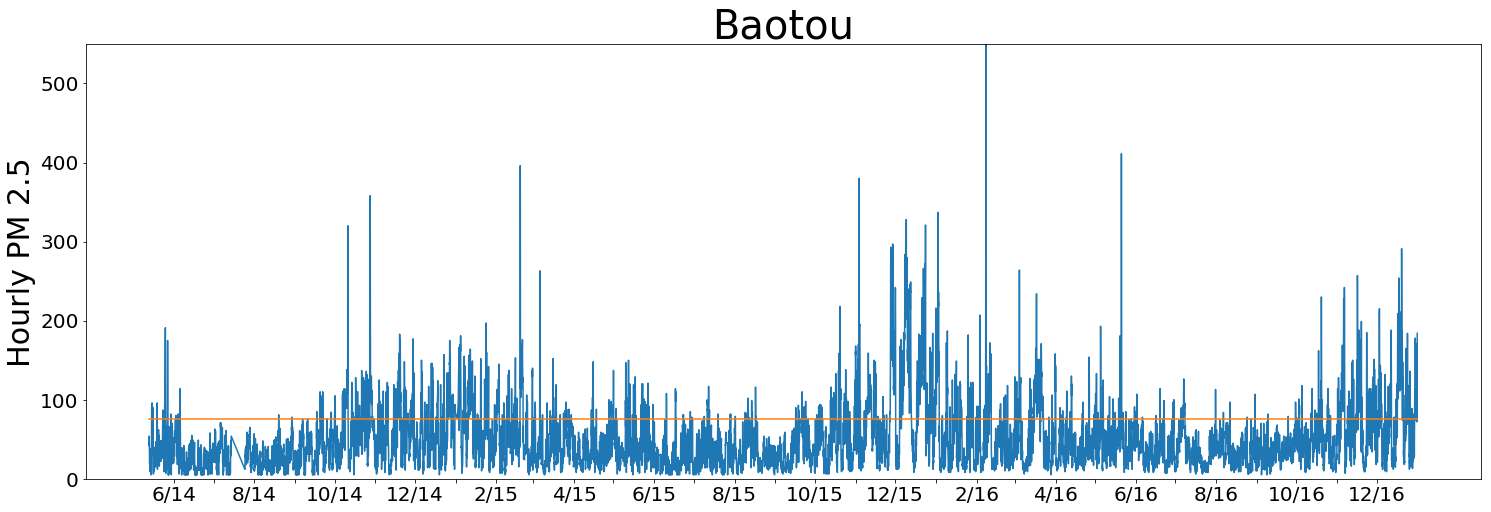

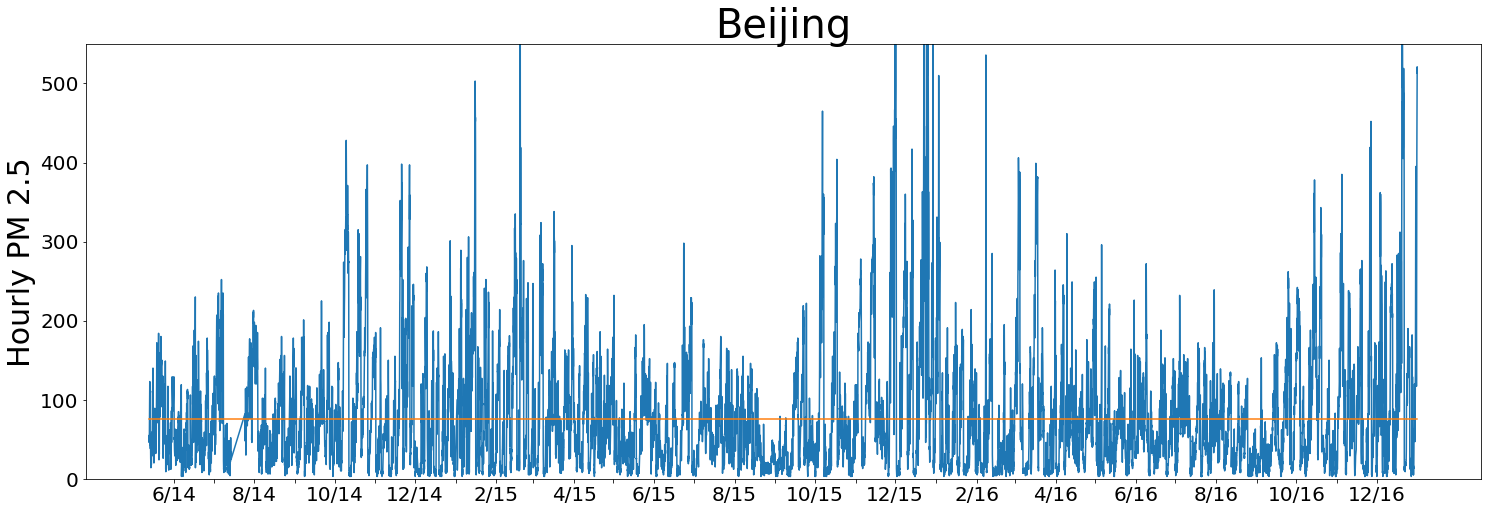

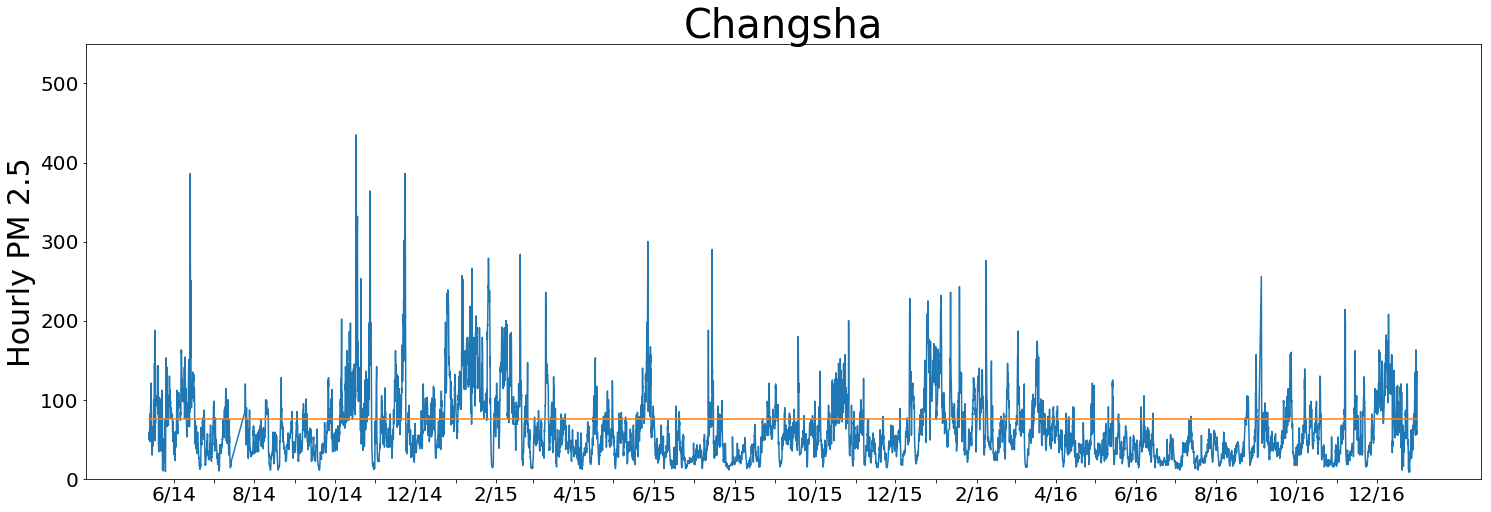

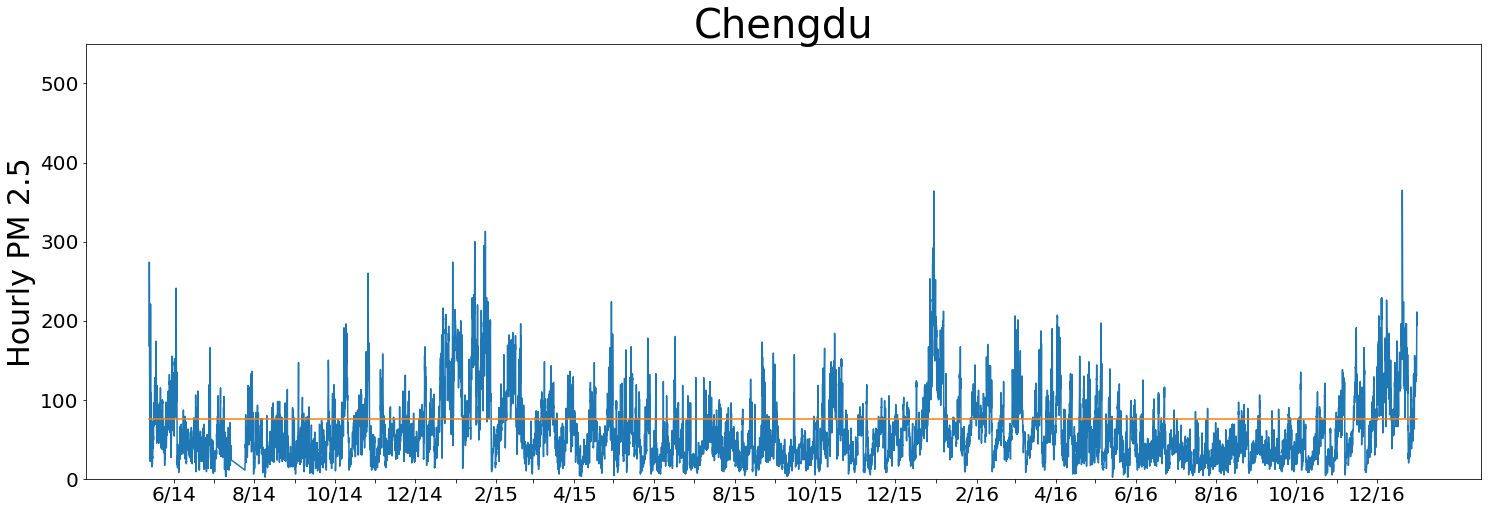

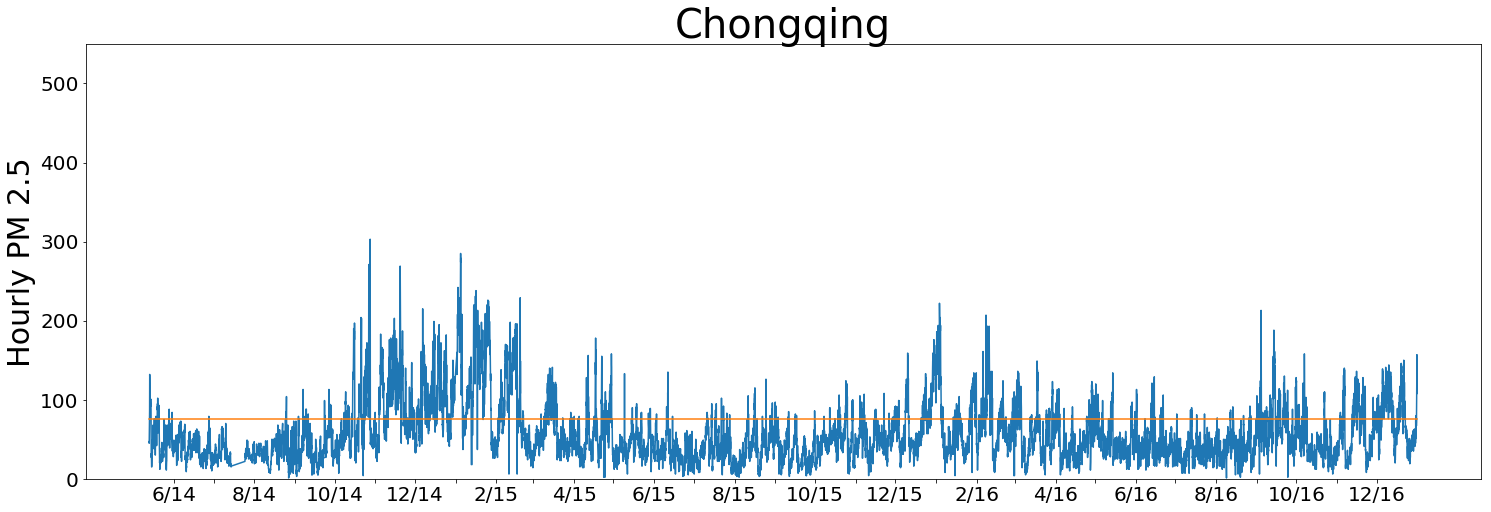

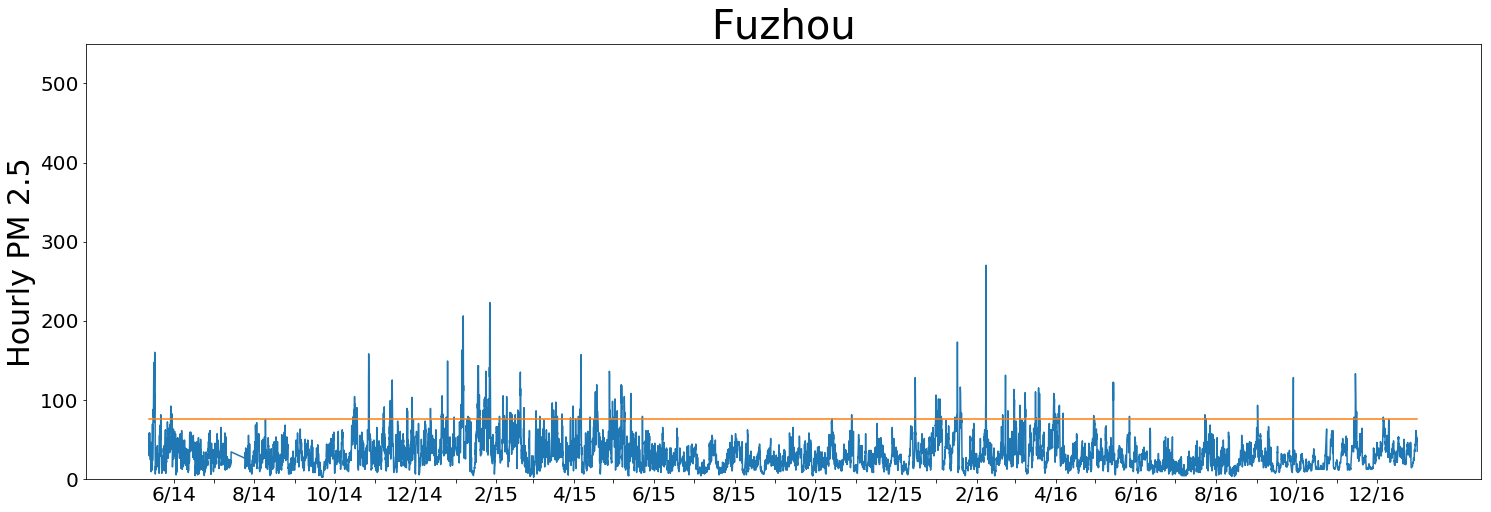

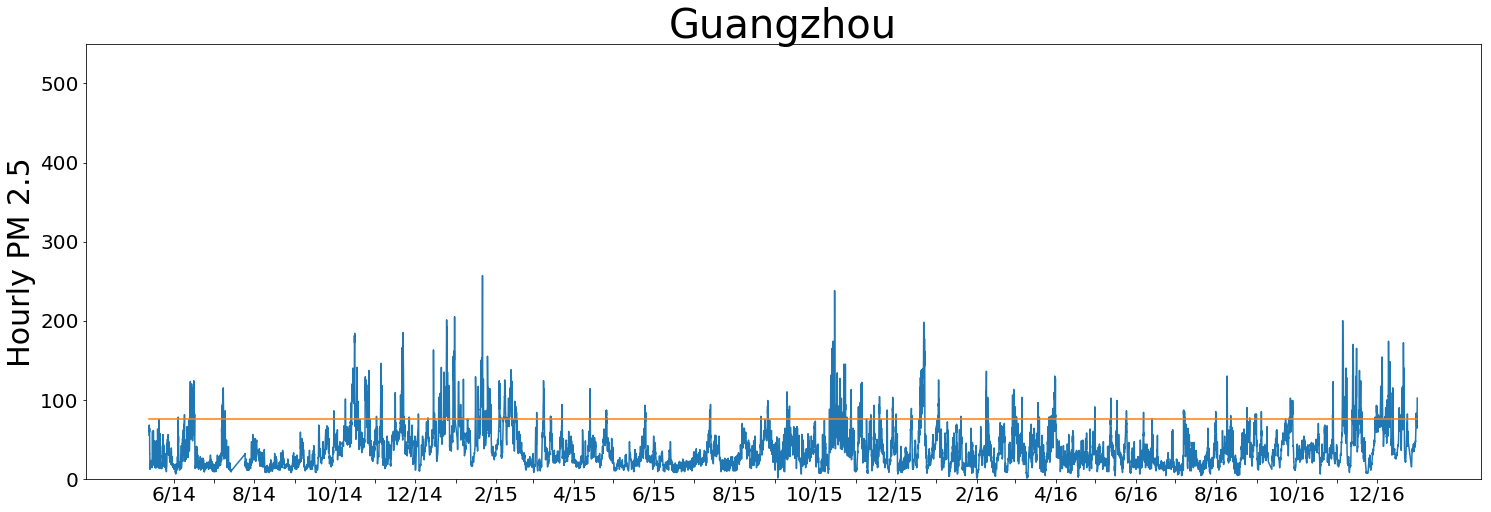

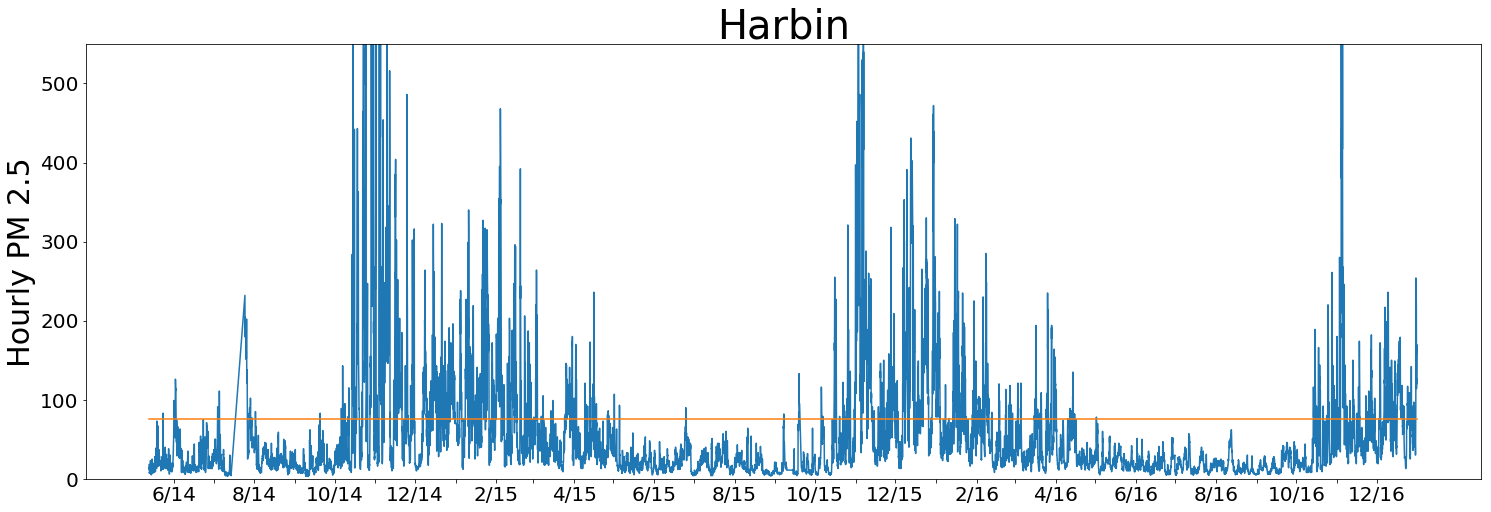

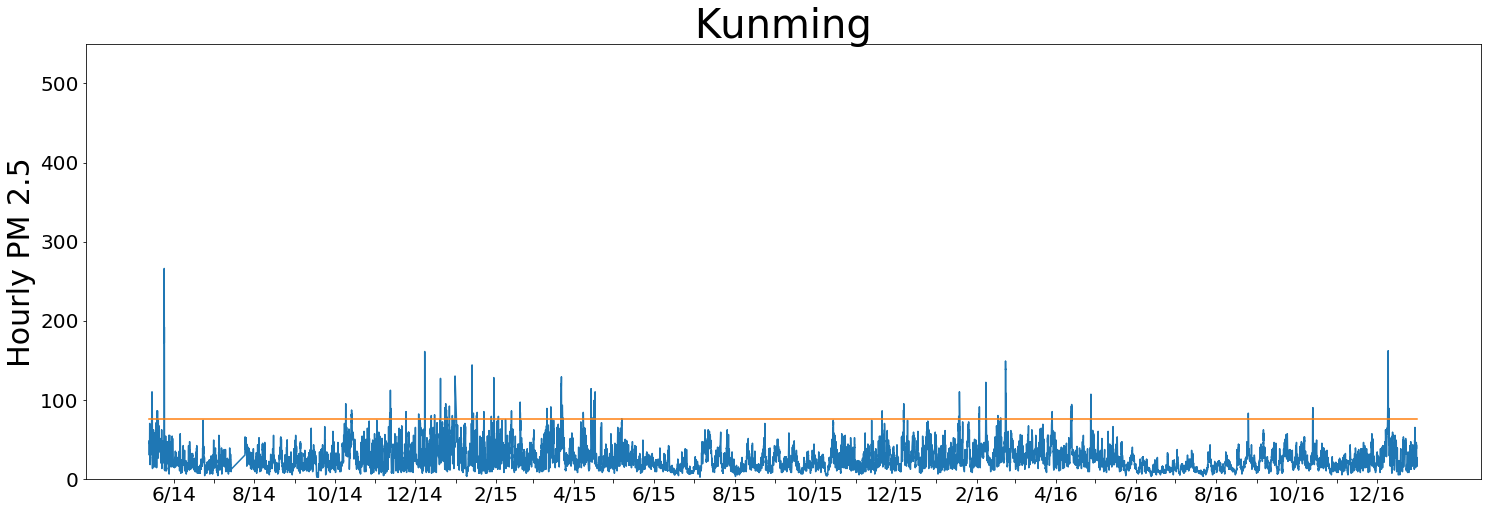

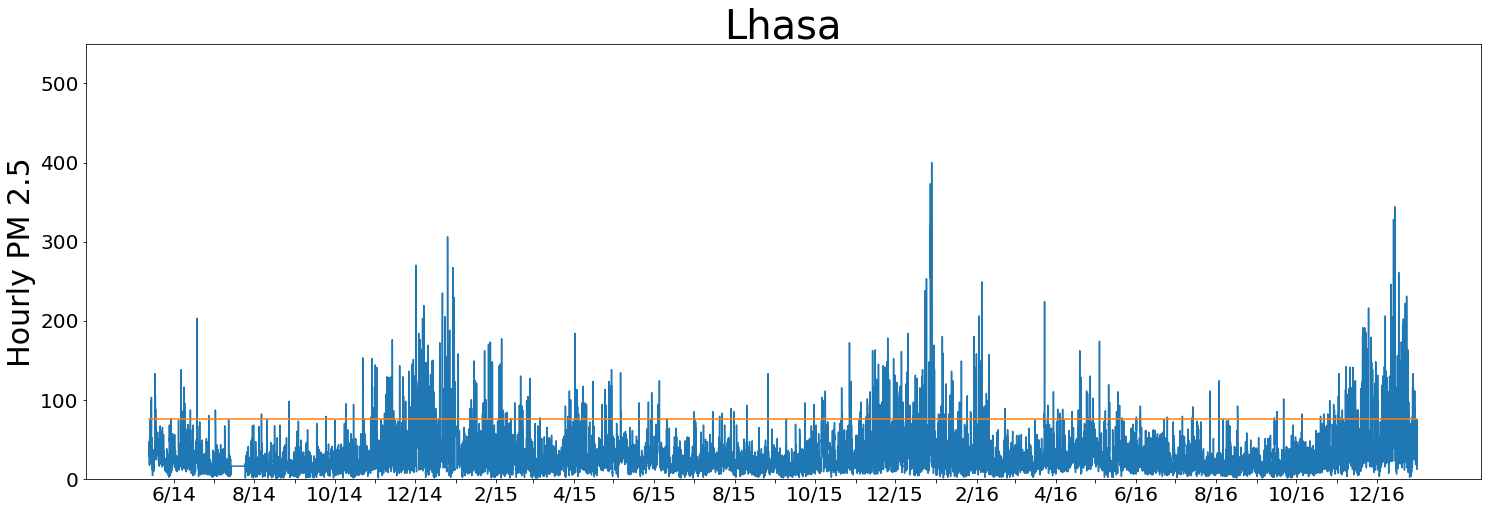

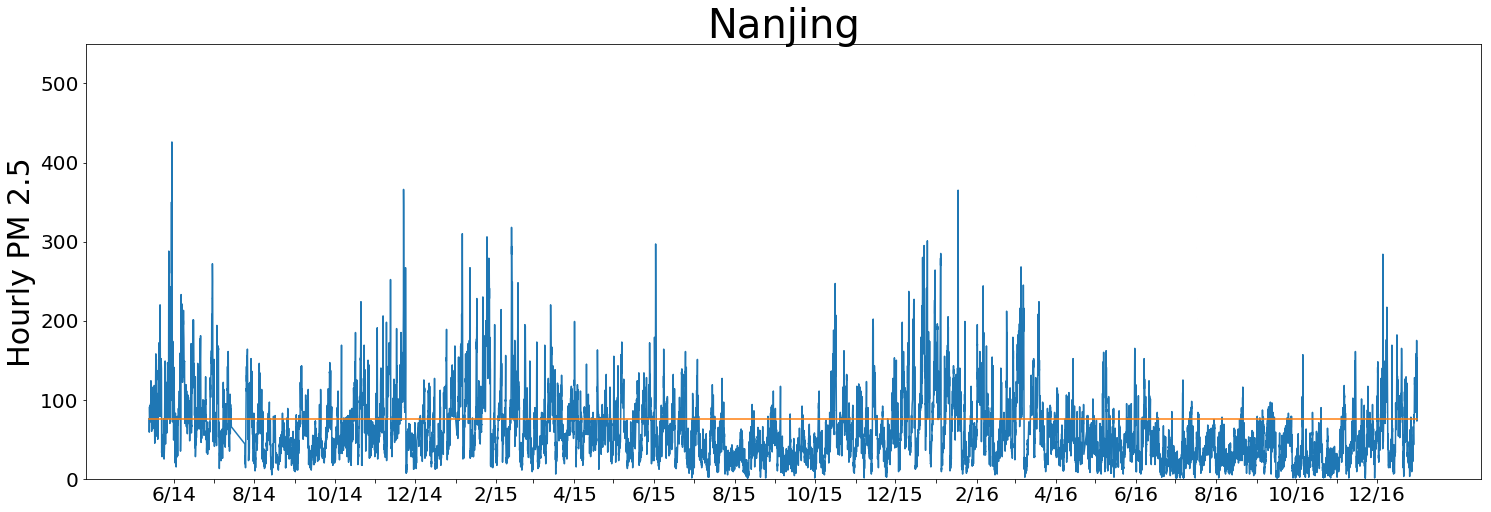

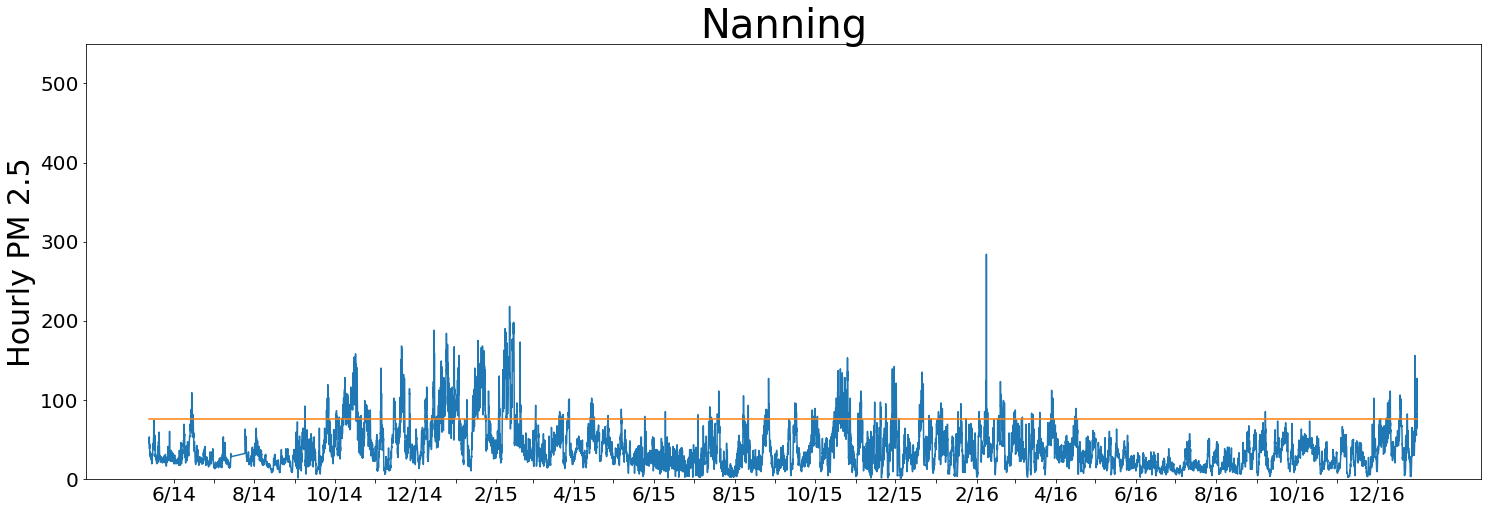

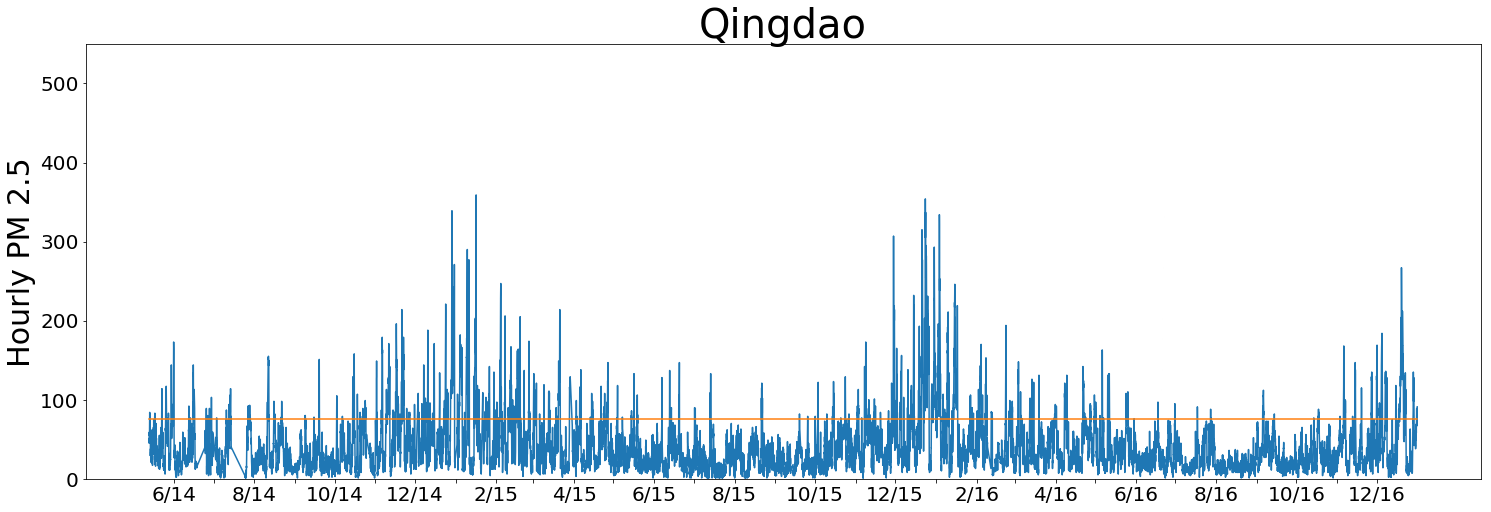

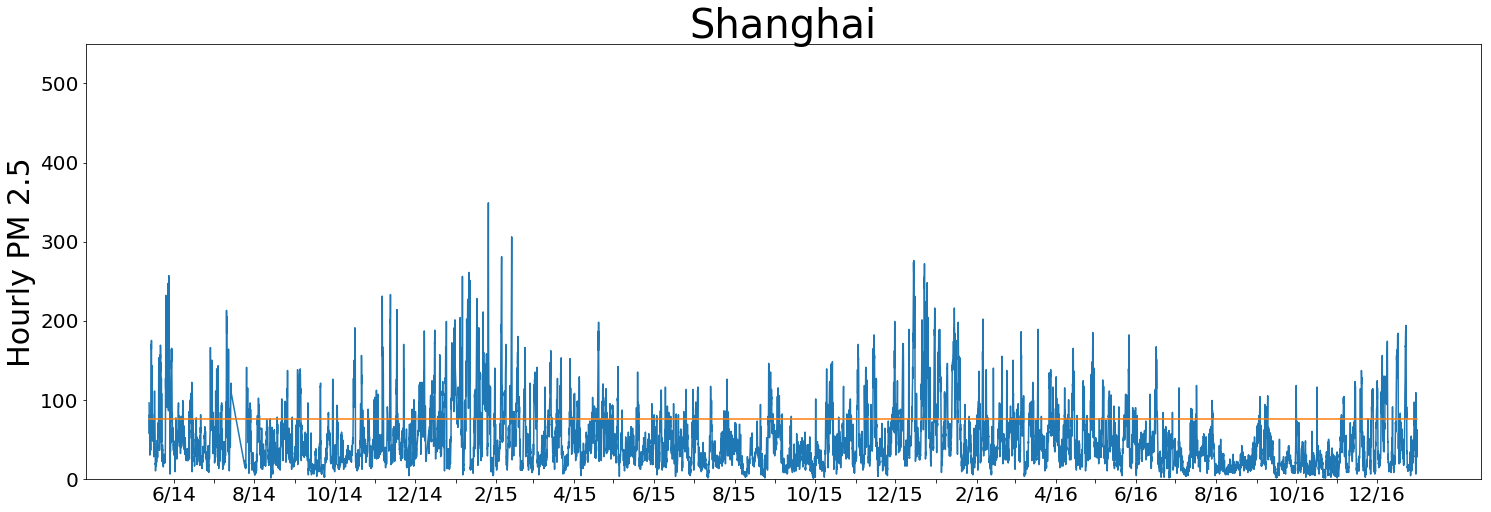

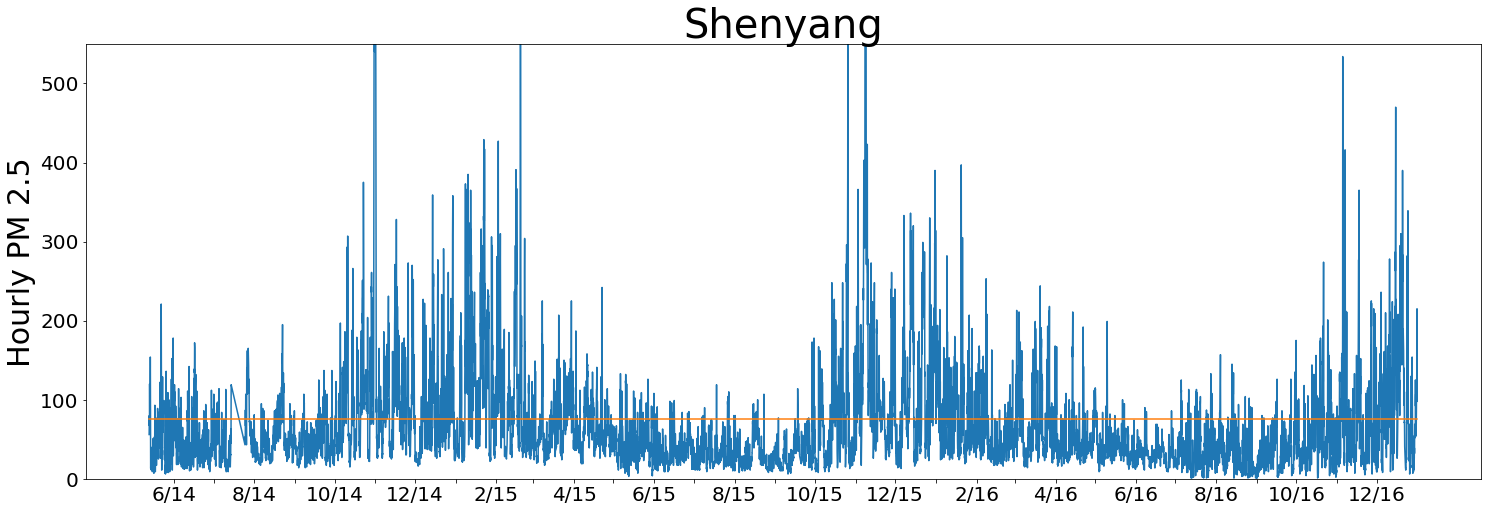

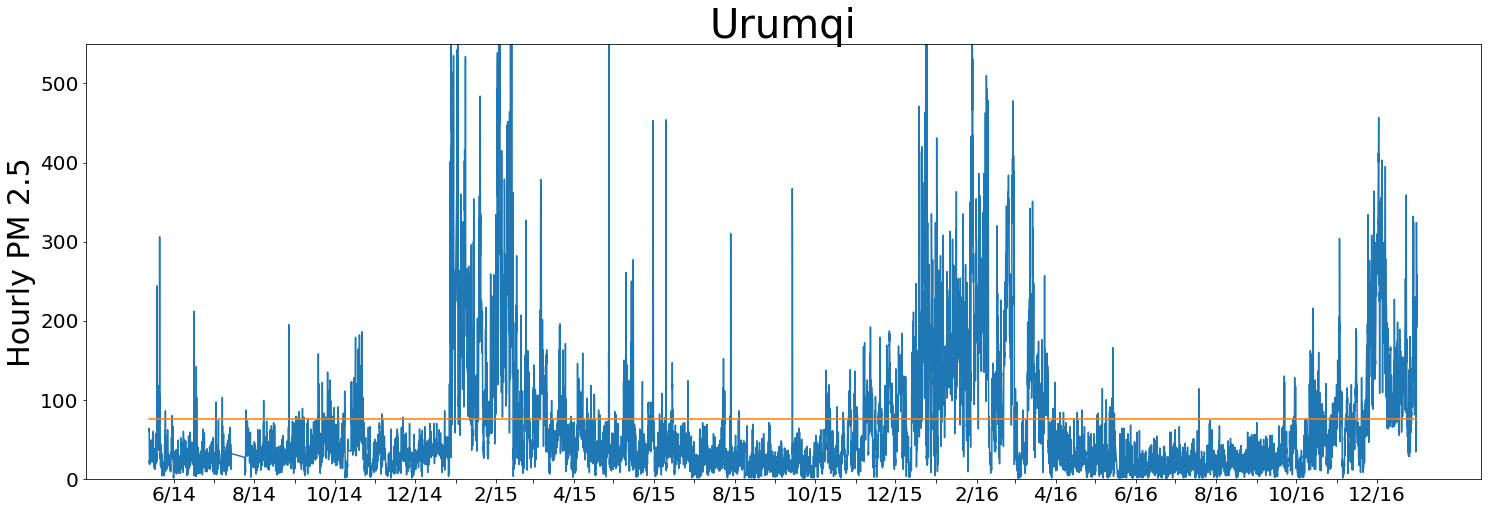

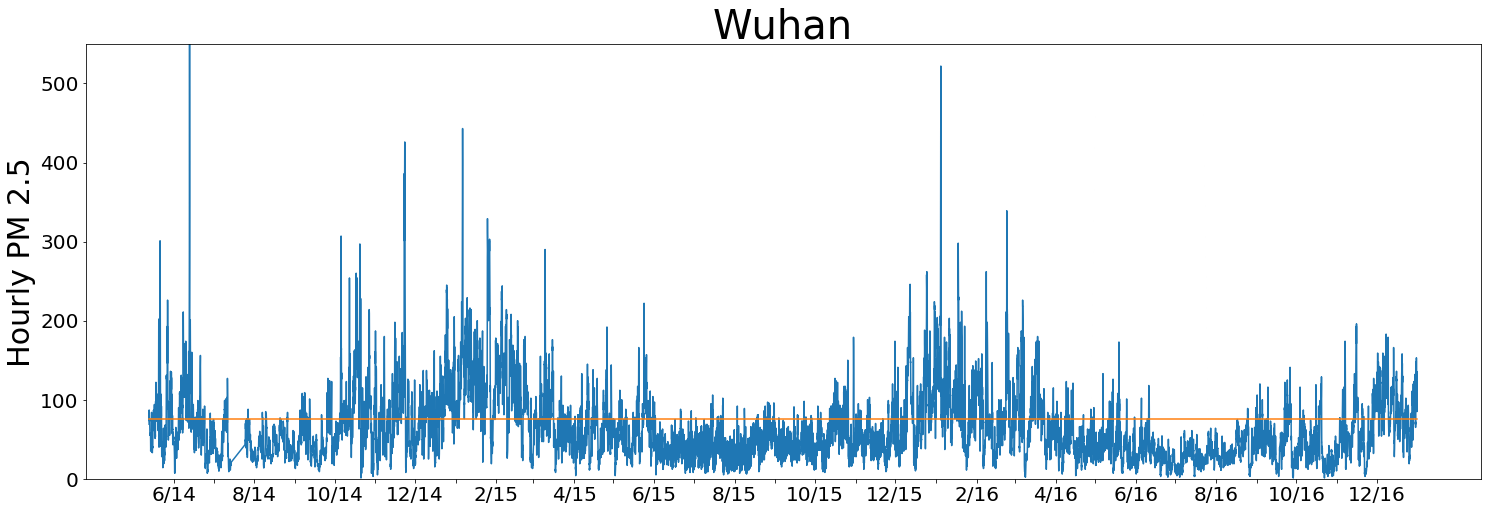

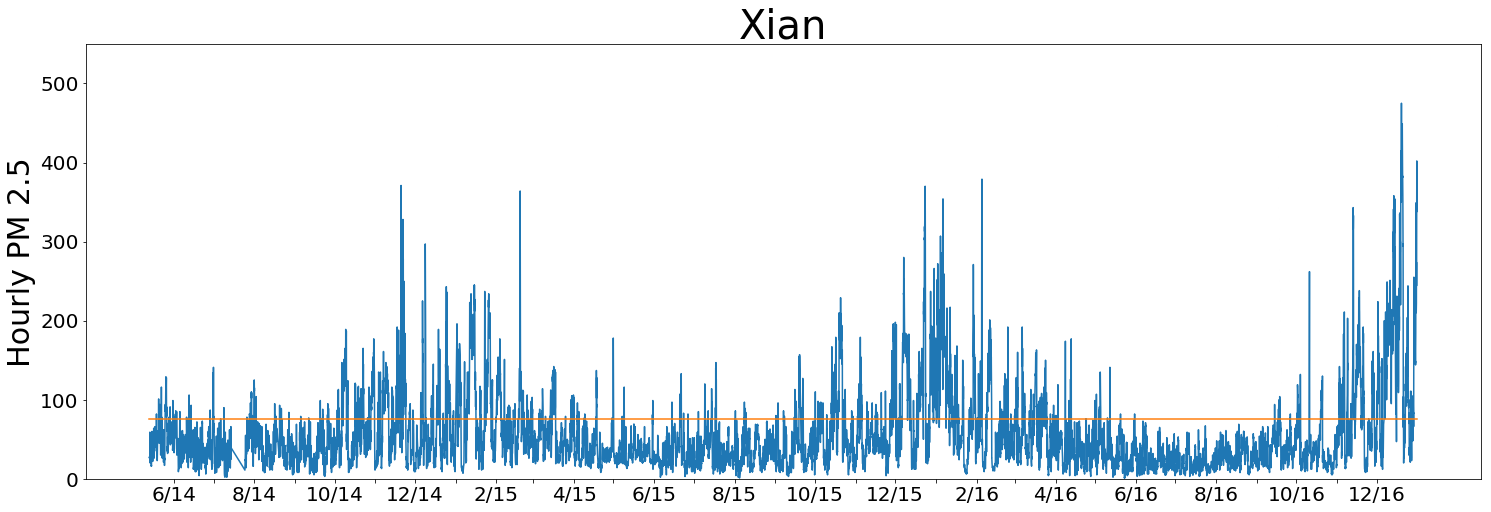

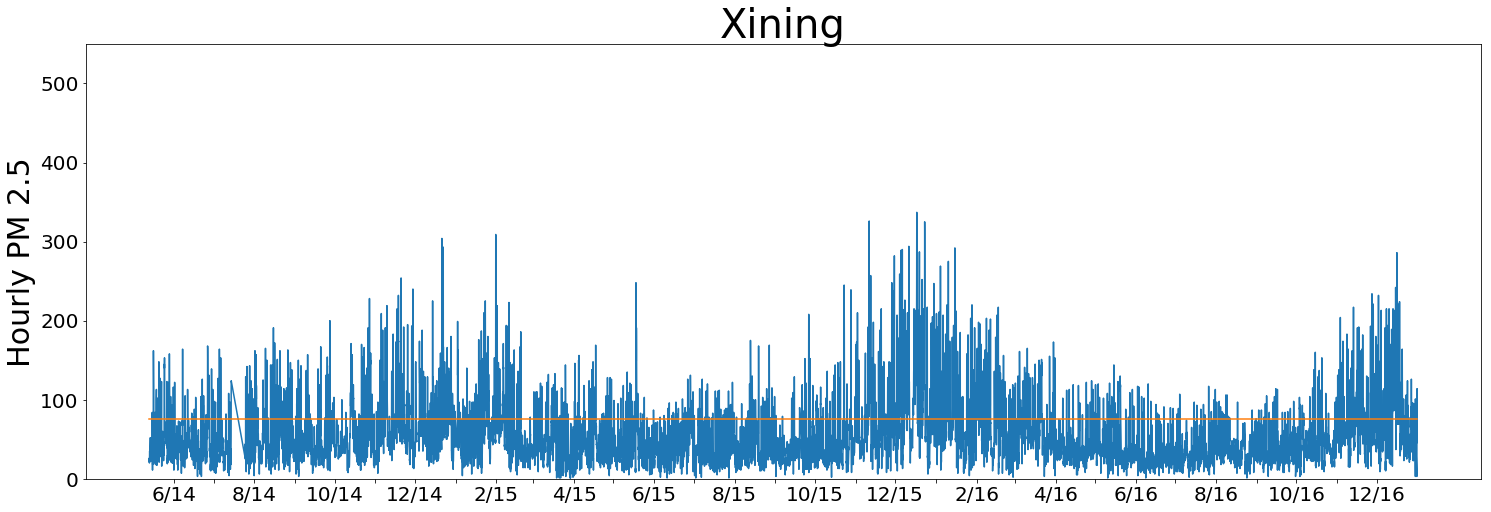

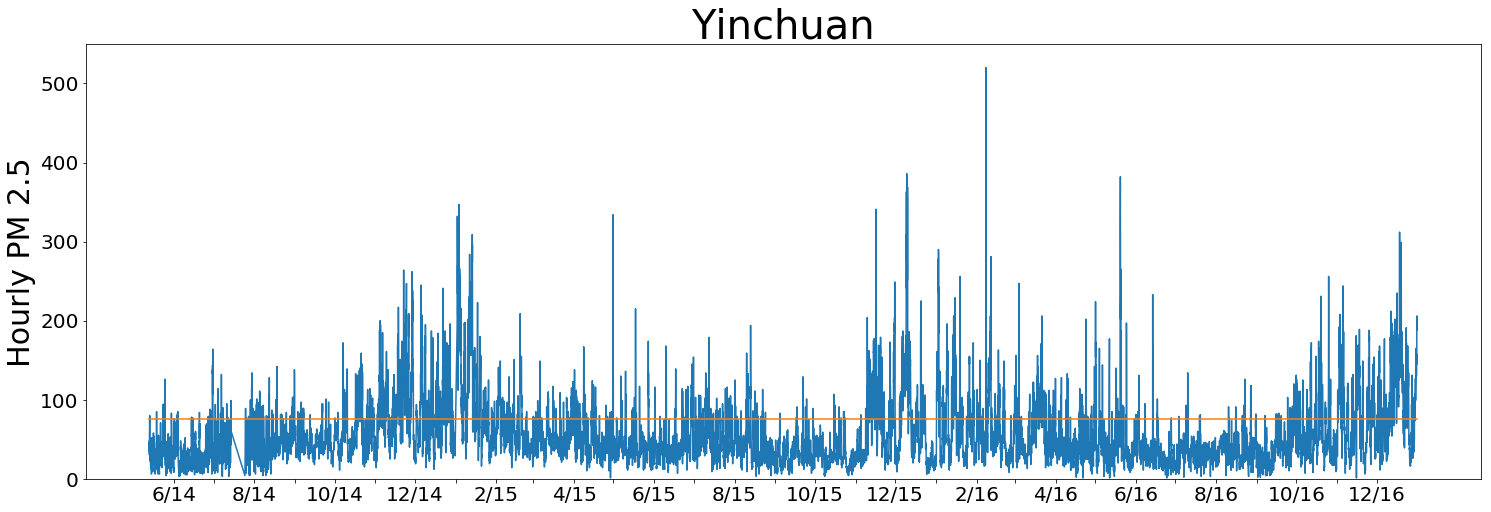

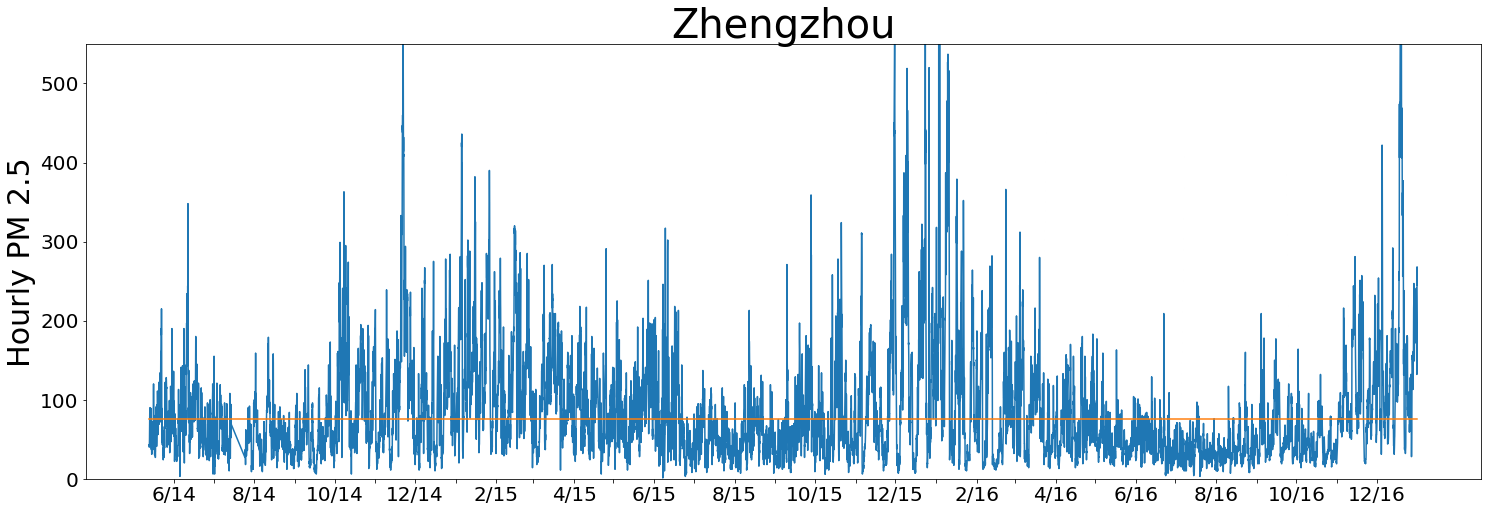

In [10]:
labels = ['6/14', '', '8/14', '', '10/14', '', '12/14', '', '2/15','','4/15','','6/15','','8/15',
          '','10/15','','12/15','','2/16','','4/16','','6/16','','8/16','','10/16','','12/16']

PM_less['year'] = PM_less['date'].map(lambda x: x.year)
month_years = PM_less.drop_duplicates(subset=['month', 'year'])
for m in range(len(stations_to_use)):
    plt.figure(figsize=[25, 8])
    name = metros_to_use[m]
    plt.plot(PM_less[name])
    plt.plot([0,23136],[75, 75])
    plt.ylim(0, 550)
    plt.ylabel('Hourly PM 2.5', size=30)
    plt.yticks(size=20)
    plt.xticks(np.array(month_years.index)[1:], labels, size=20)
    plt.title(name, size=40)

# Plot average daily PM2.5 over time (per day) for all stations 

In [24]:
PM_DayAvg = PM_less.groupby('date').mean().reset_index()
PM_DayAvg.head()

date  month  weekday  hour     Baotou    Beijing    Changsha  \
0  2014-05-13      5        1  11.5  26.895833  64.875000   59.500000   
1  2014-05-14      5        2  11.5  23.875000  27.958333   82.000000   
2  2014-05-15      5        3  11.5  63.000000  77.687500   42.979167   
3  2014-05-16      5        4  11.5  17.604167  60.875000   66.208333   
4  2014-05-17      5        5  11.5  26.333333  71.333333  108.000000   

      Chengdu  Chongqing     Fuzhou  ...     Qingdao   Shanghai   Shenyang  \
0  109.937500  83.541667  36.541667  ...   62.145833  59.208333  90.791667   
1   91.458333  63.208333  26.333333  ...   33.958333  89.125000  26.541667   
2   25.958333  37.312500  39.708333  ...   33.604167  69.791667  18.604167   
3   67.541667  55.208333  94.062500  ...   53.750000  56.583333  27.000000   
4   98.458333  56.958333  86.625000  ...   45.791667  61.750000  37.187500   

      Urumqi      Wuhan       Xian     Xining   Yinchuan  Zhengzhou  year  
0  31.187500  67.575758  27.270833  31.979167  45.208333  62.812500  2014  
1  32.166667  49.674242  26.708333  34.708333  17.541667  54.333333  2014  
2  31.708333  40.750000  38.791667  33.750000  23.083333  44.875000  2014  
3  29.020833  74.395833  42.833333  62.895833  36.291667  64.750000  2014  
4  24.083333  69.208333  50.208333  38.583333  19.250000  46.083333  2014  

[5 rows x 26 columns]

In [25]:
month_years.index

Int64Index([    0,   456,  1176,  1920,  2664,  3384,  4128,  4848,  5592,
             6336,  7008,  7752,  8472,  9216,  9936, 10680, 11424, 12144,
            12888, 13608, 14352, 15096, 15792, 16536, 17256, 18000, 18720,
            19464, 20208, 20928, 21672, 22392],
           dtype='int64')

/Users/Brenton/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


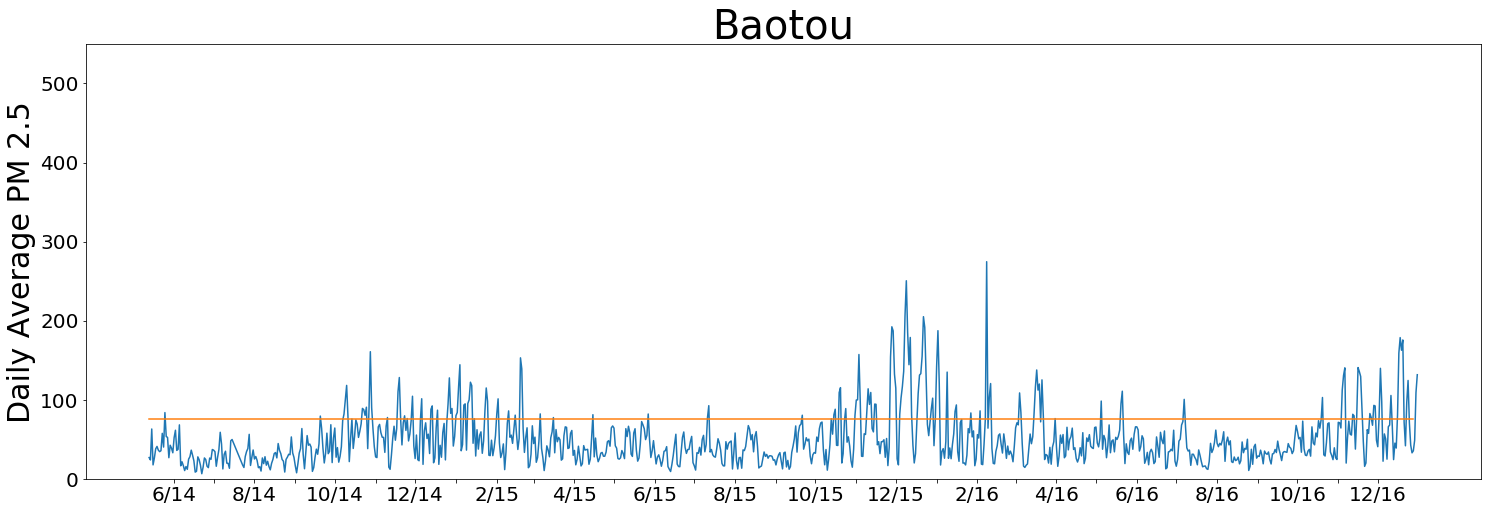

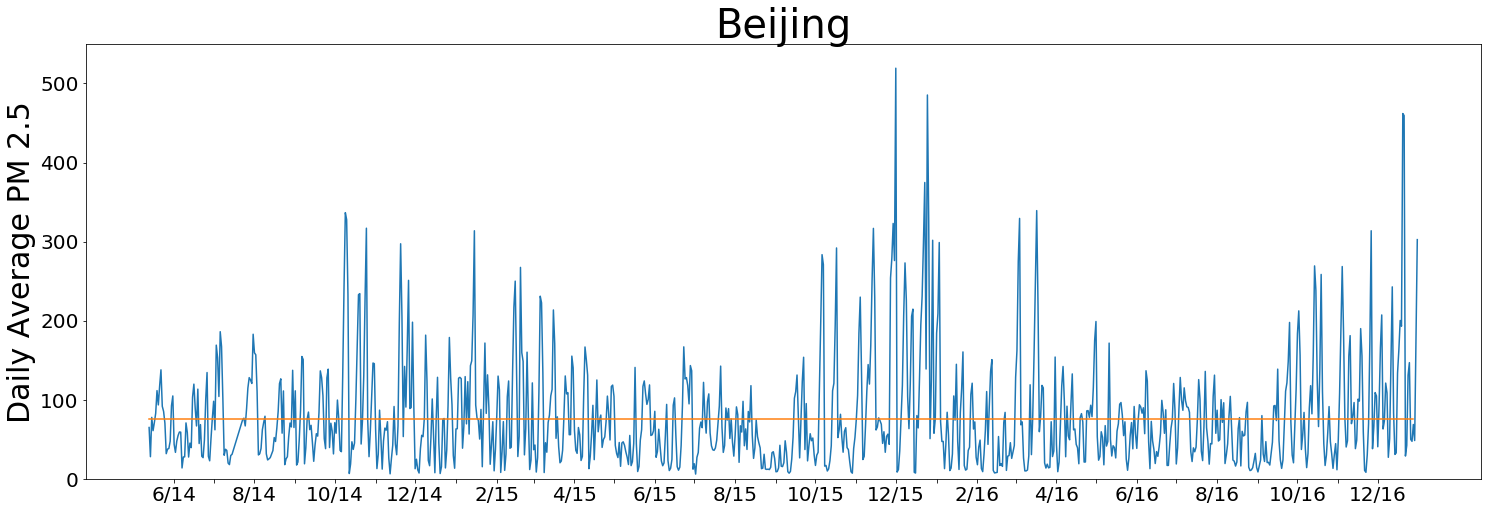

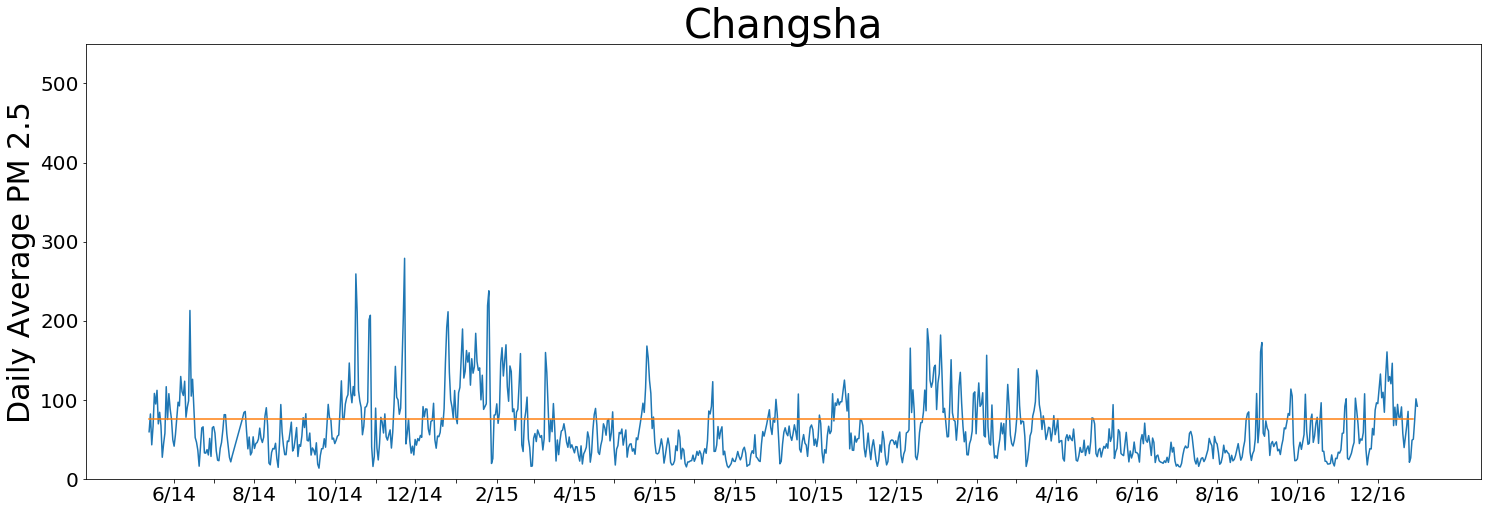

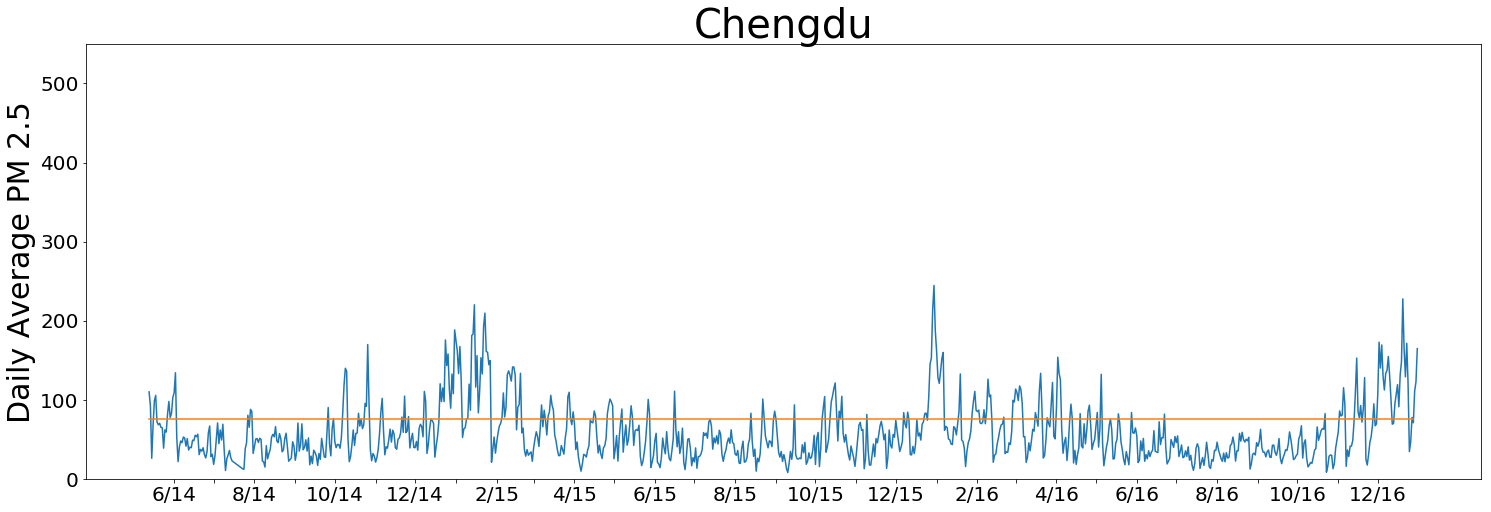

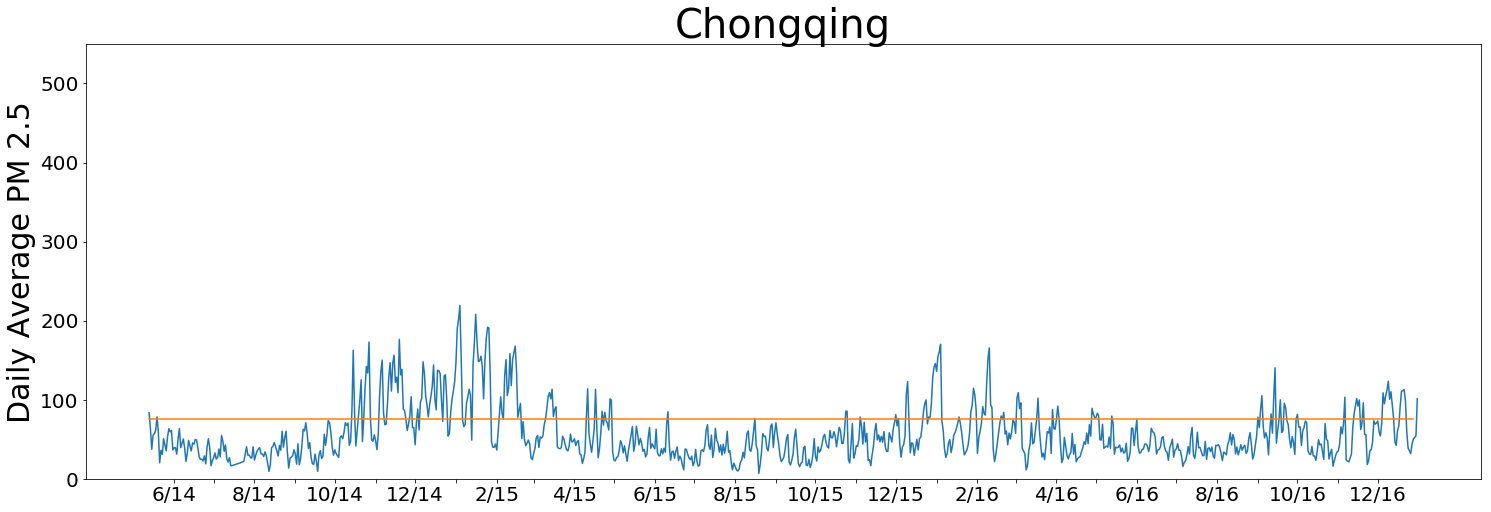

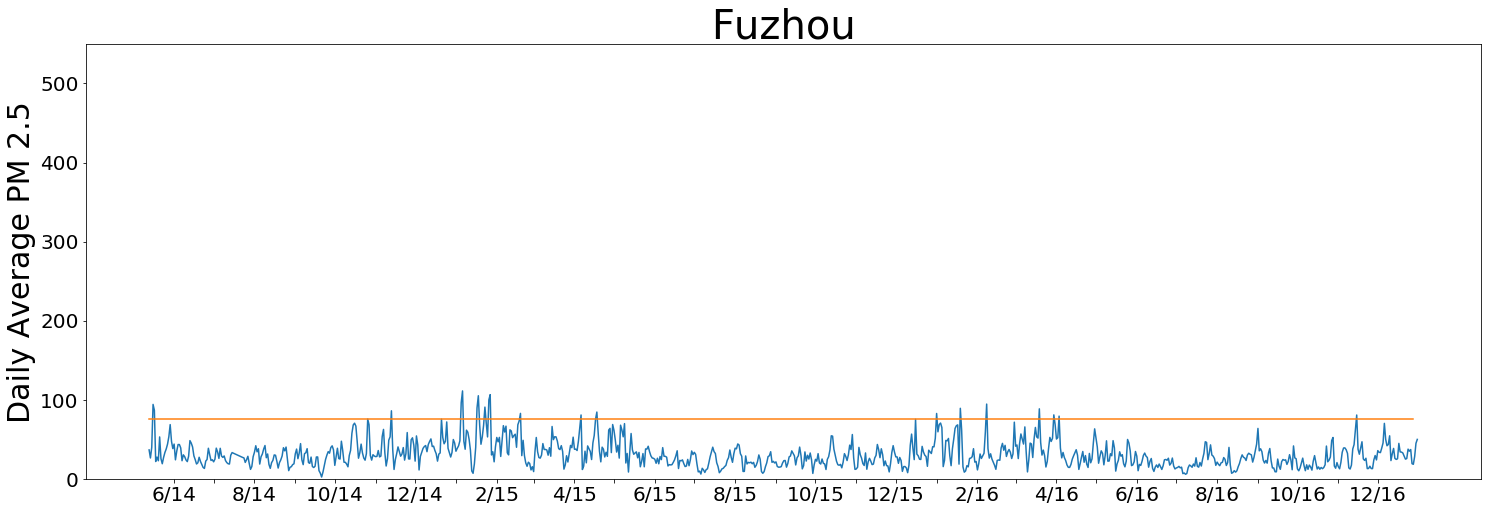

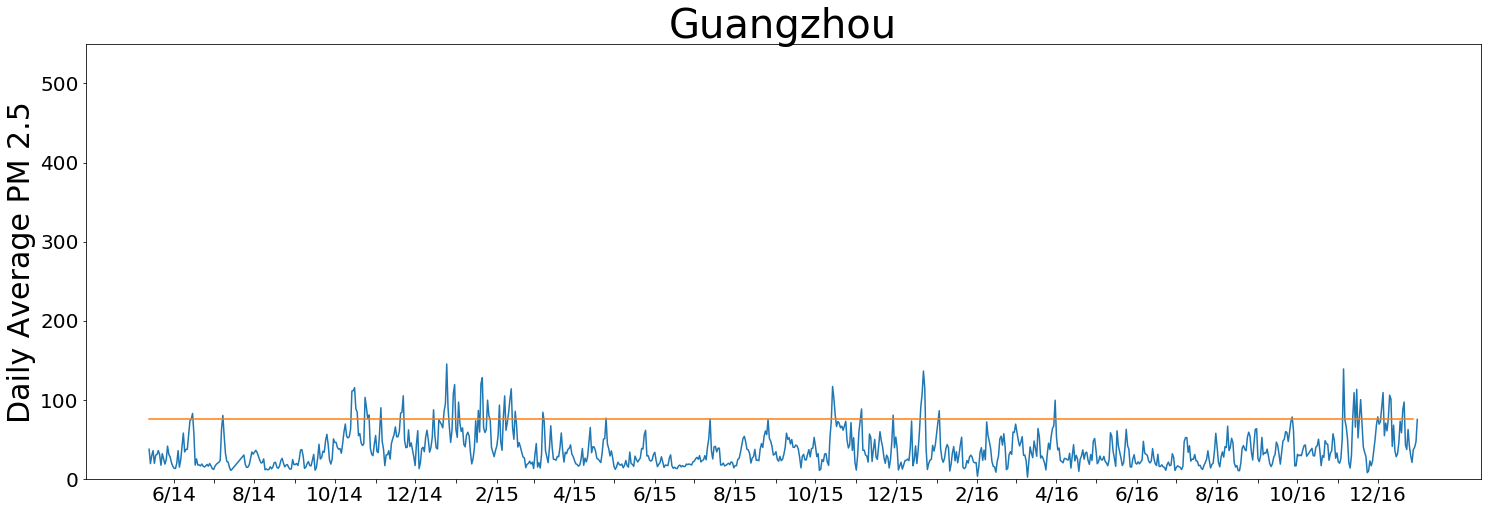

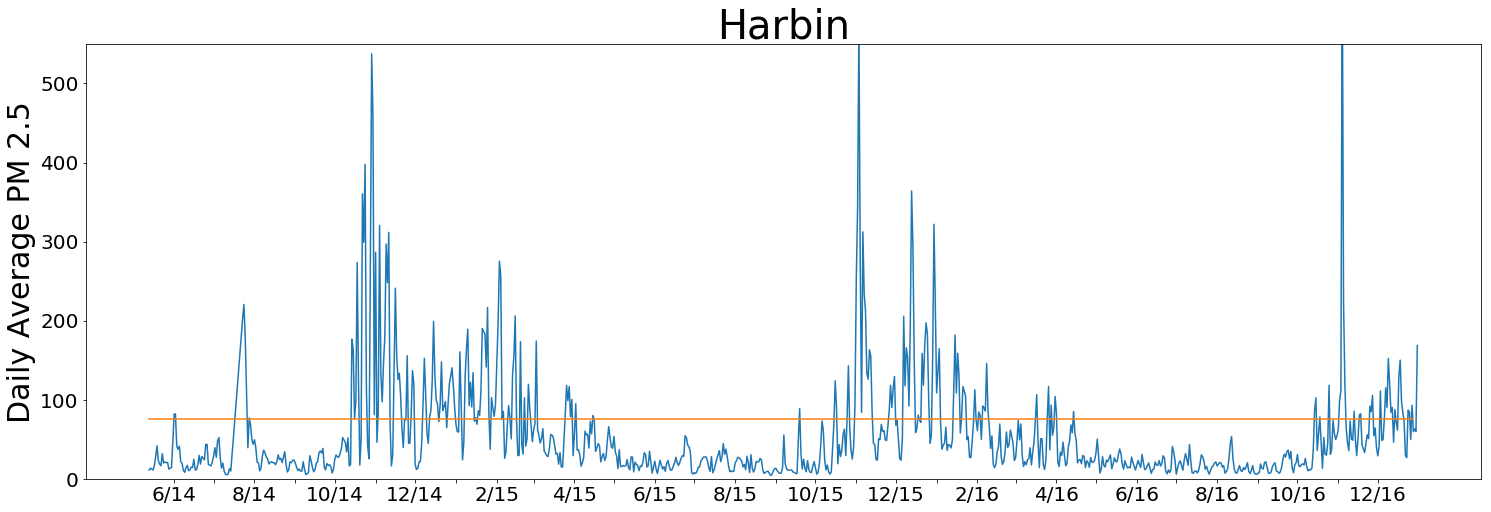

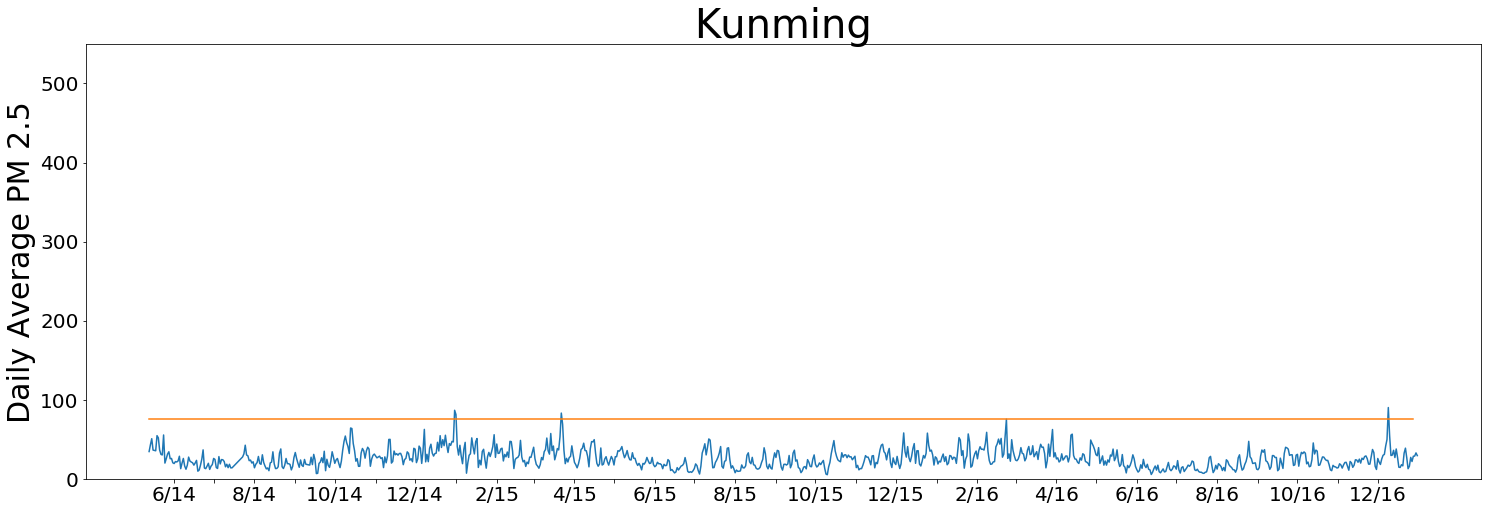

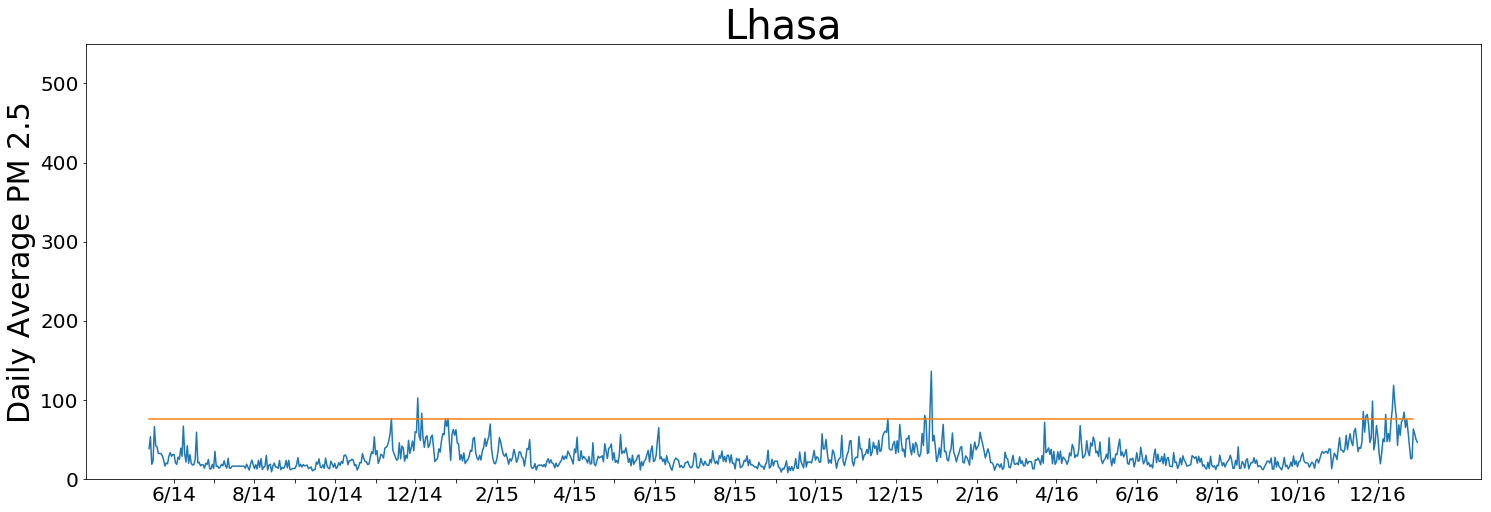

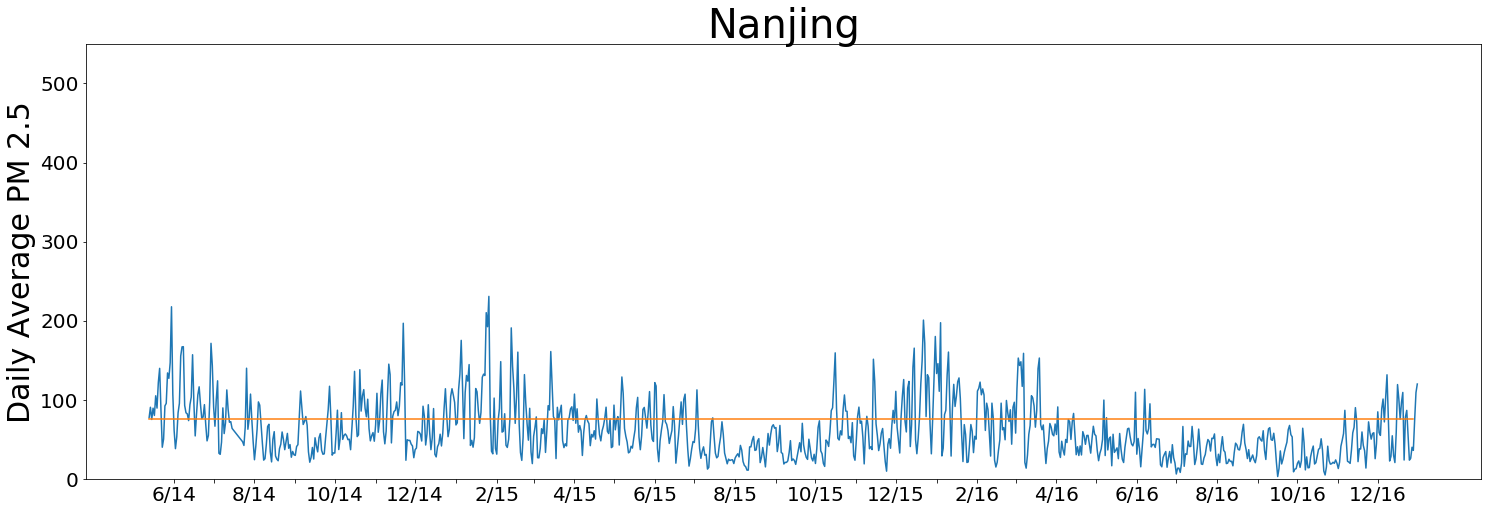

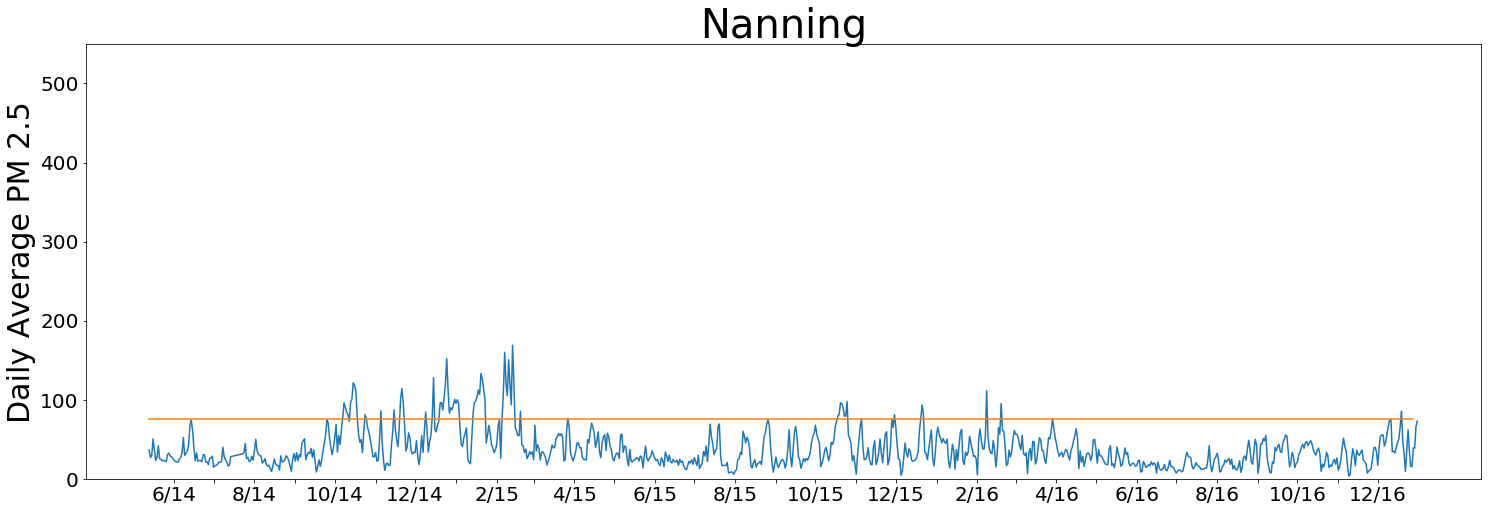

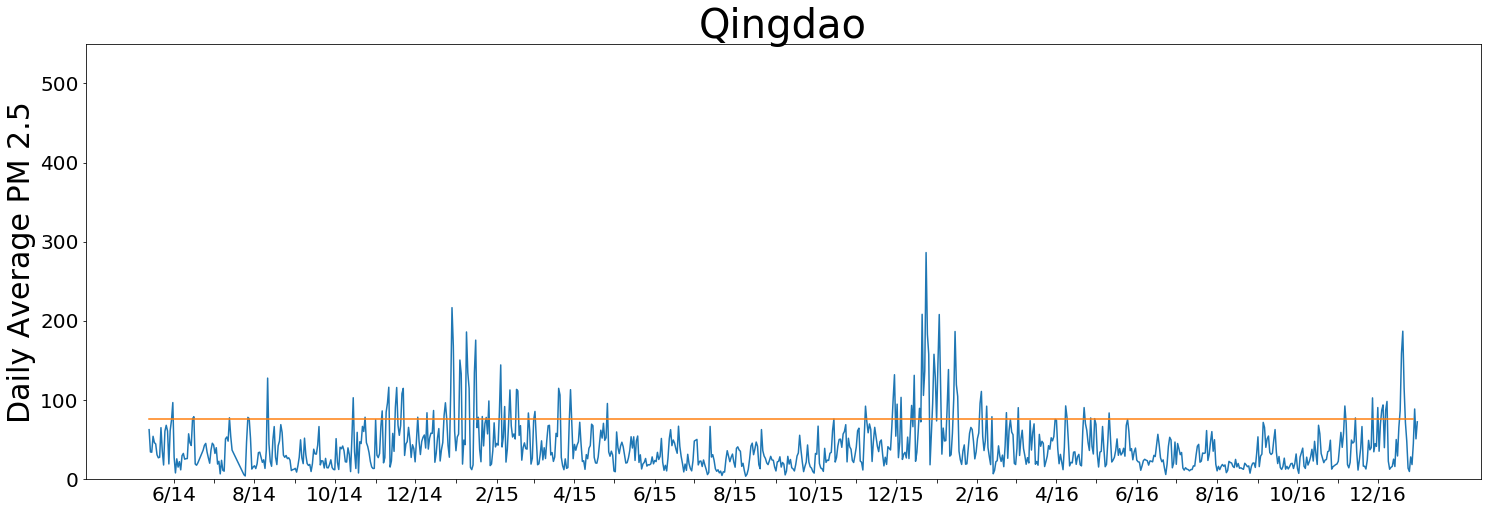

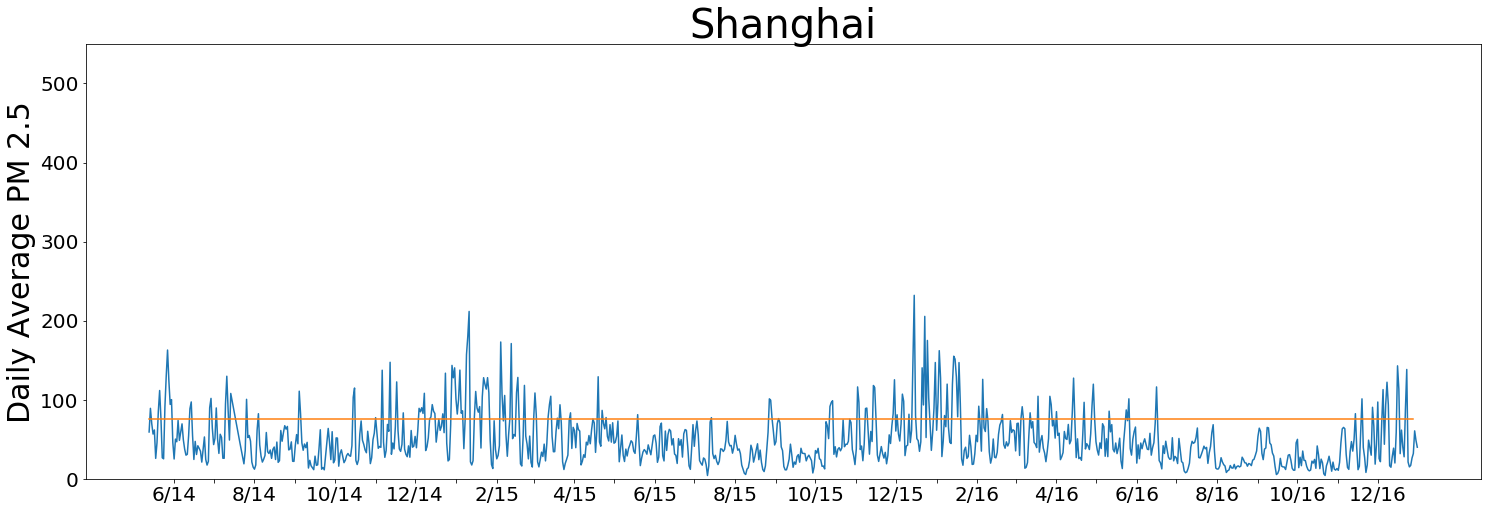

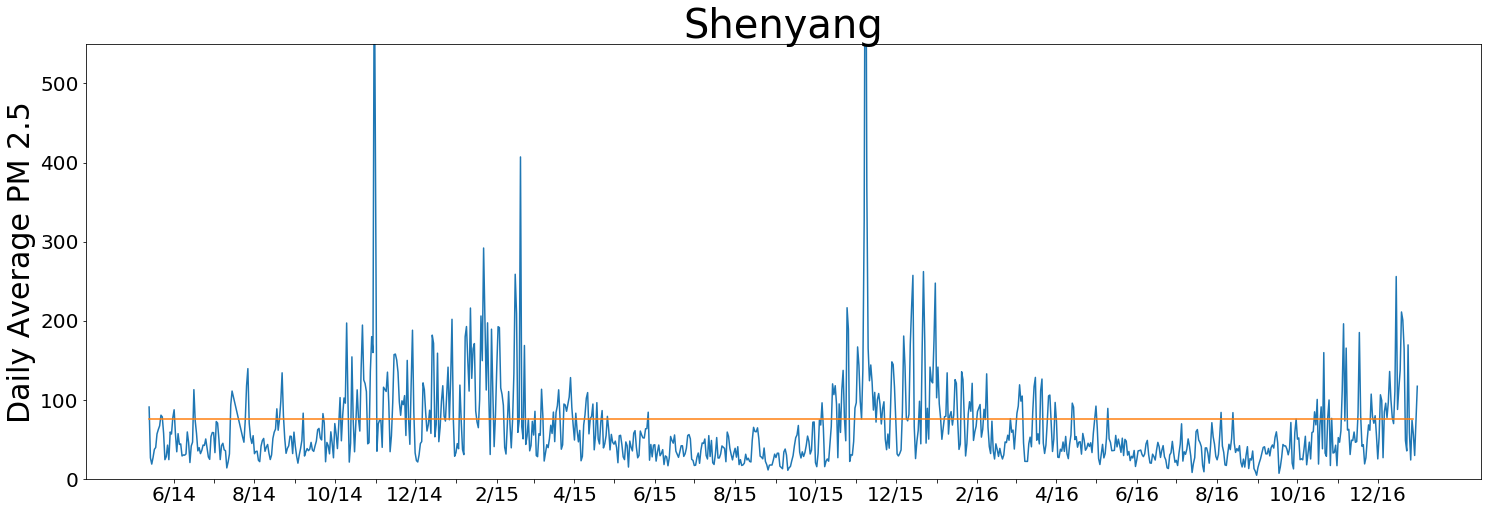

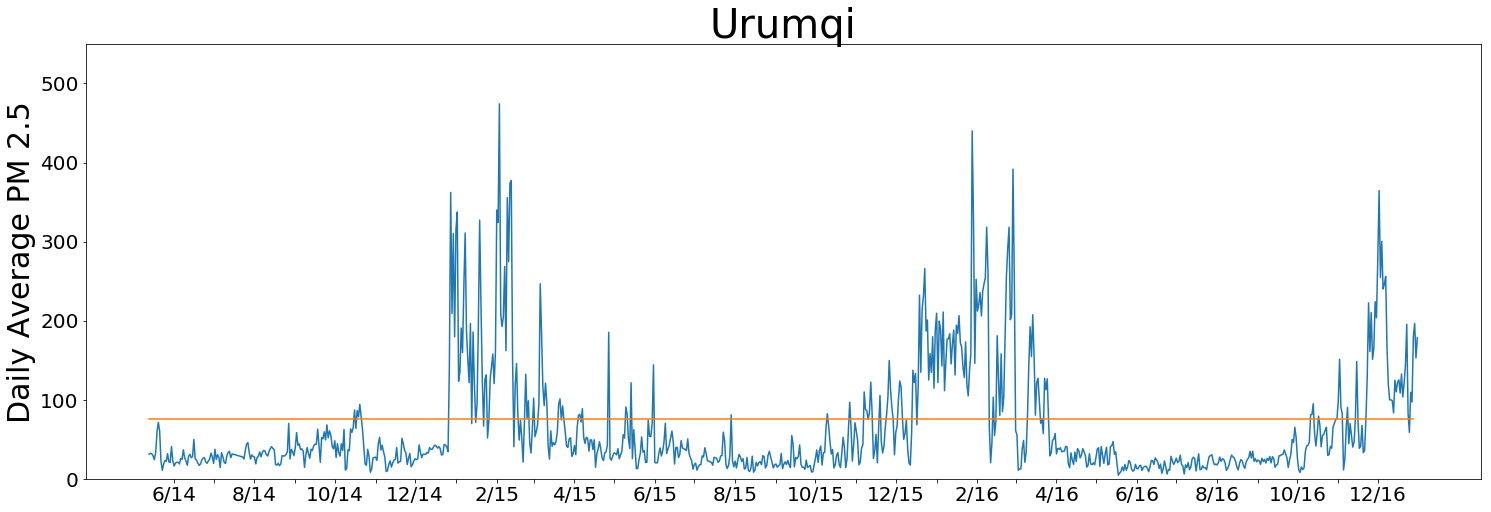

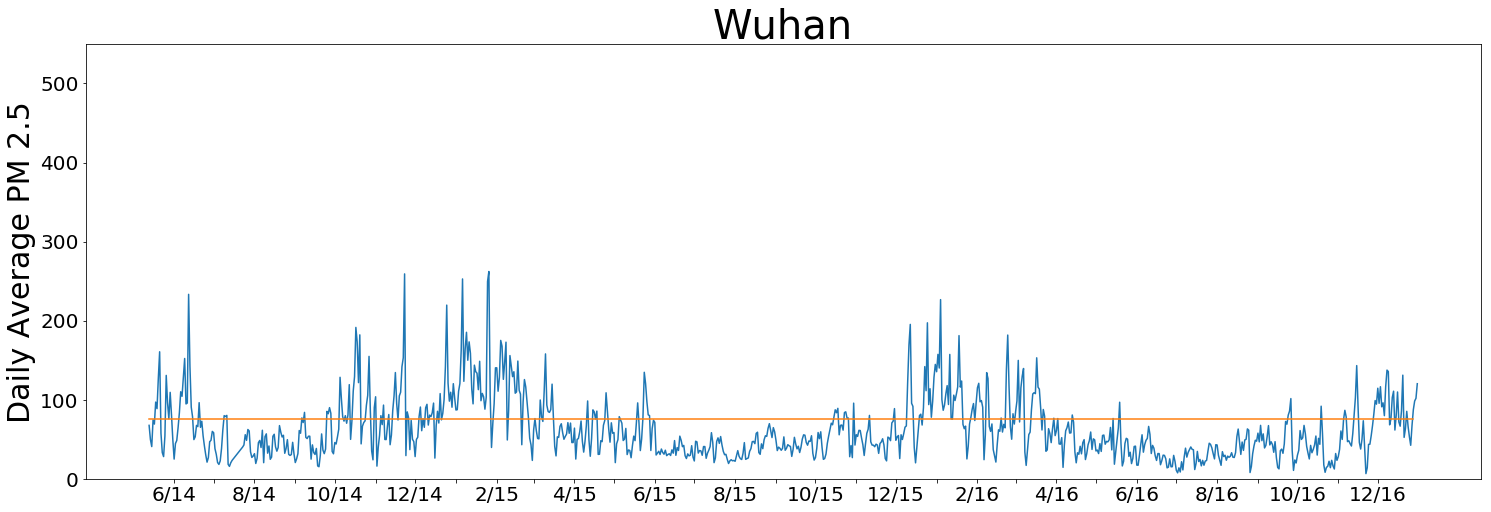

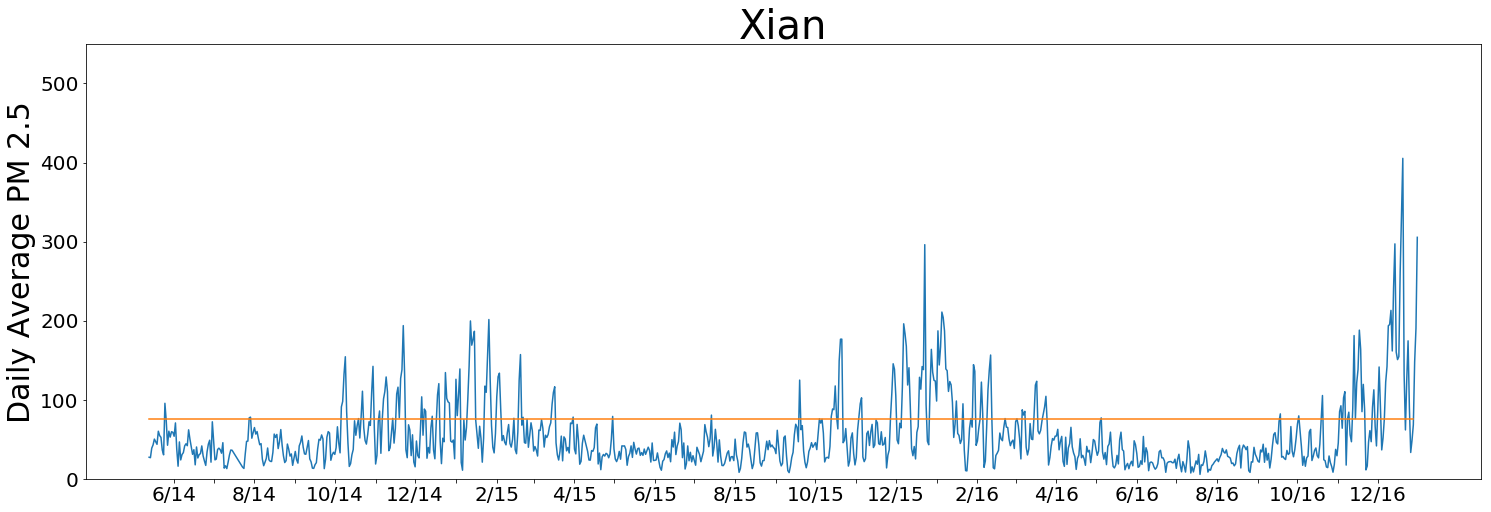

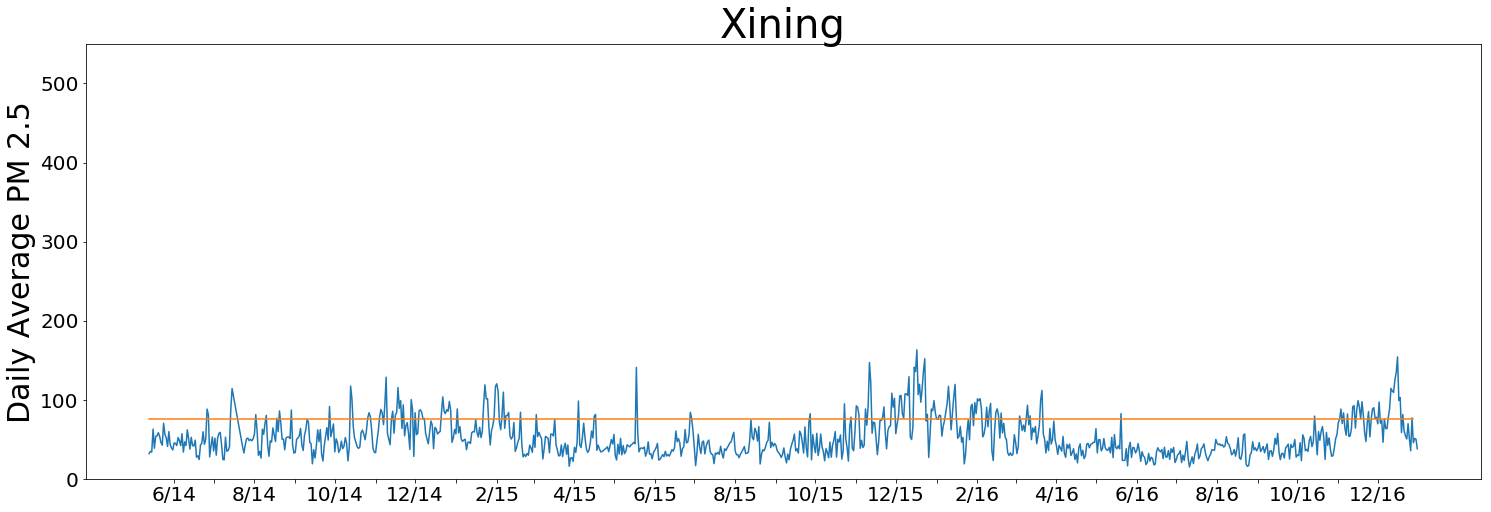

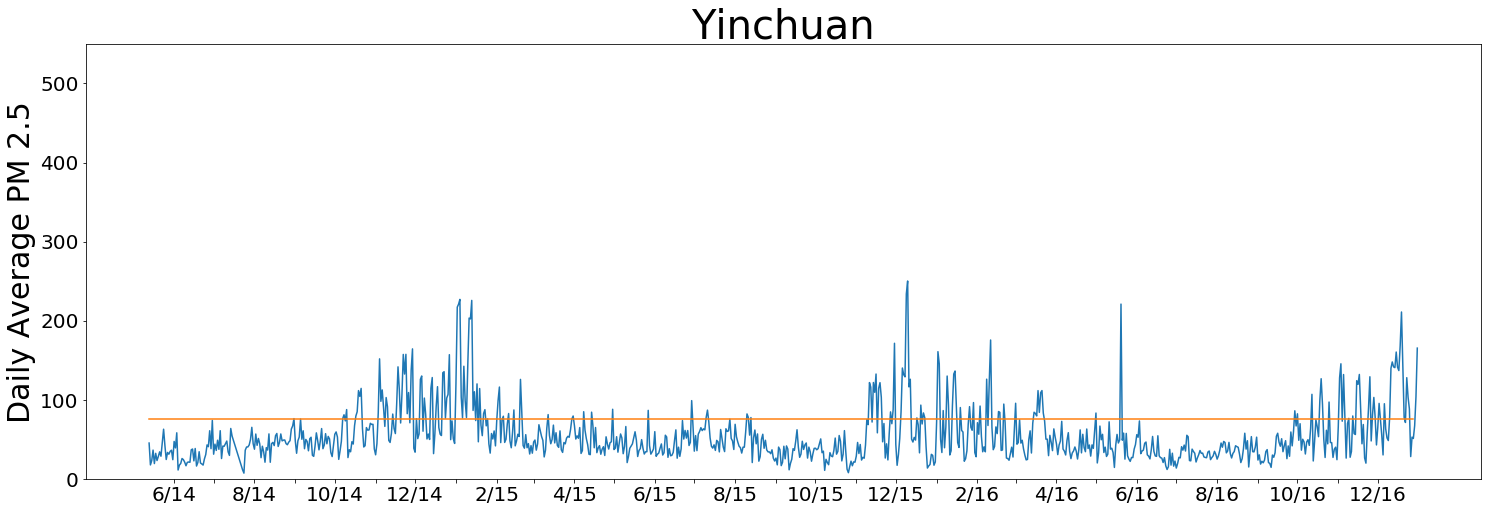

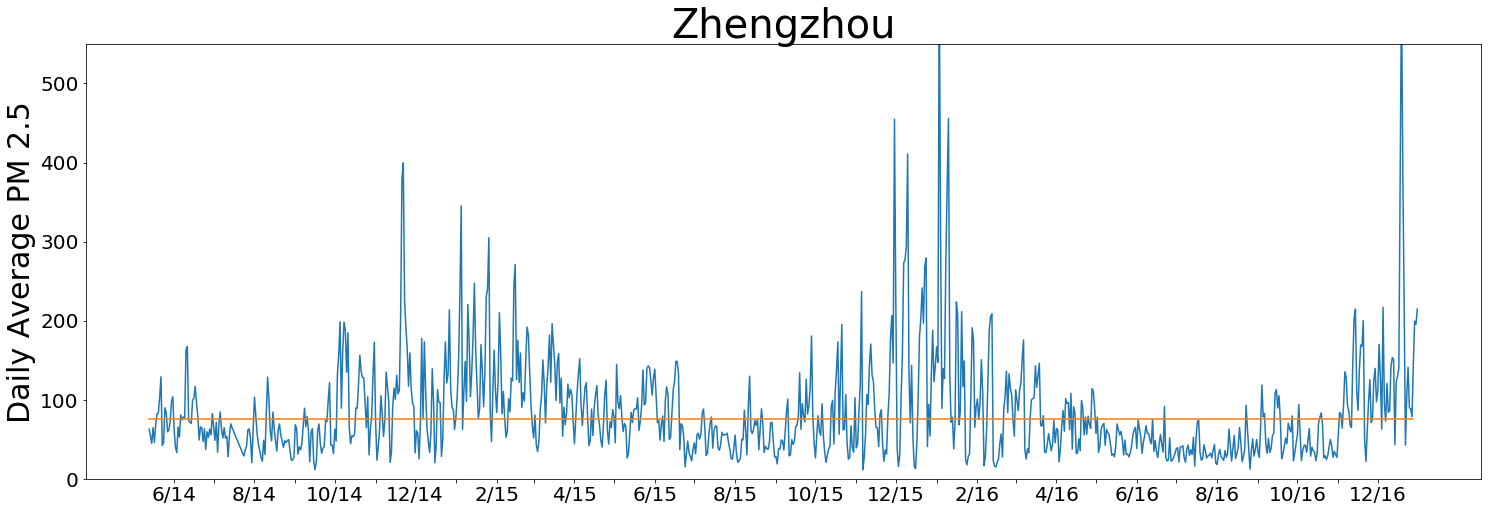

In [26]:
month_years = PM_DayAvg.drop_duplicates(subset=['month', 'year'])
labels = ['6/14', '', '8/14', '', '10/14', '', '12/14', '', '2/15','','4/15','','6/15','','8/15',
          '','10/15','','12/15','','2/16','','4/16','','6/16','','8/16','','10/16','','12/16']

for m in range(len(stations_to_use)):
    plt.figure(figsize=[25, 8])
    name = metros_to_use[m]
    plt.plot(PM_DayAvg[name])
    plt.plot([0,960],[75, 75])
    plt.ylim(0, 550)
    plt.ylabel('Daily Average PM 2.5', size=30)
    plt.yticks(size=20)
    plt.xticks(np.array(month_years.index)[1:], labels, size=20)
    plt.title(name, size=40)

# Look at sqrt(PM 2.5) and log(PM 2.5) -- hourly 

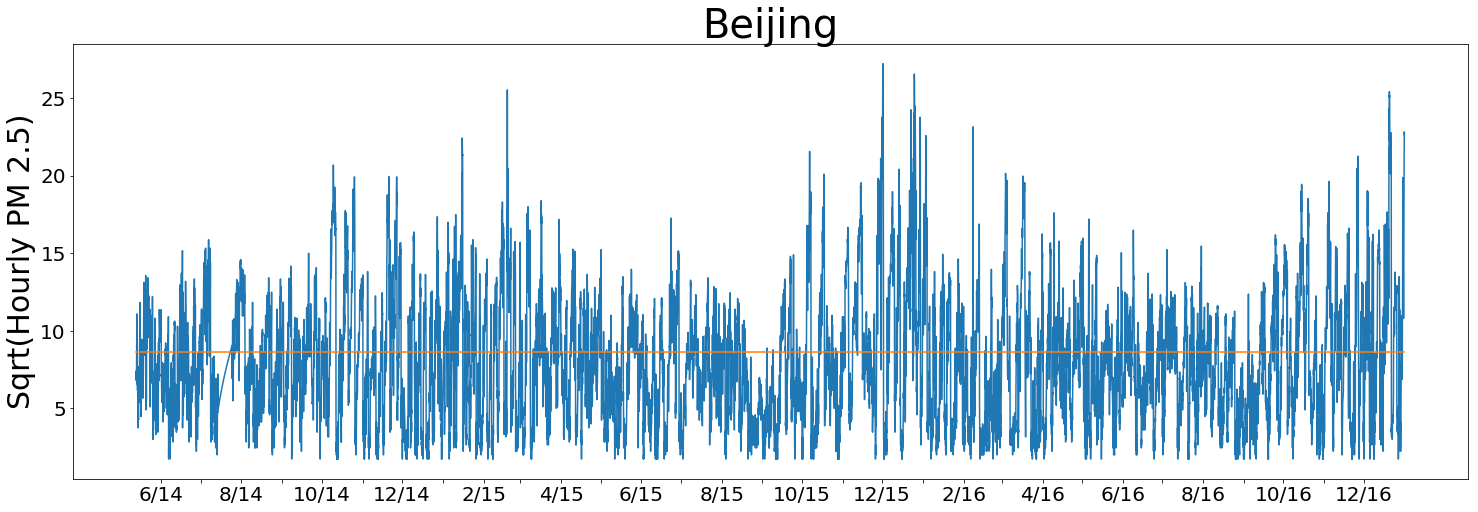

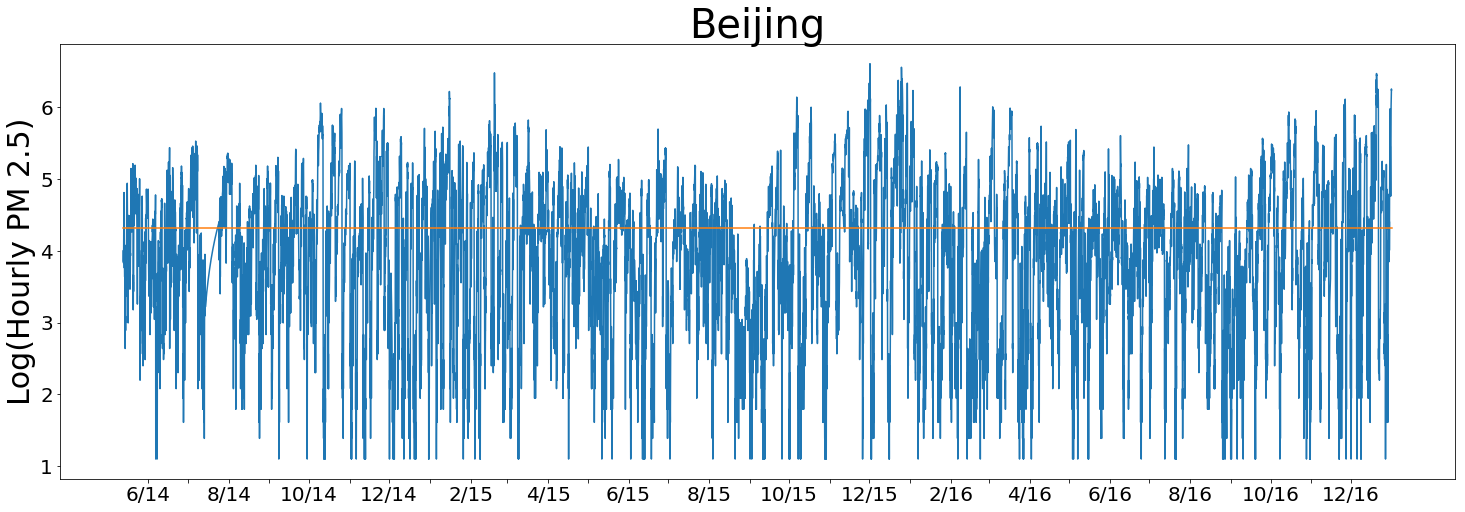

In [37]:
month_years = PM_less.drop_duplicates(subset=['month', 'year'])

for m in range(len(stations_to_use)):
    if m != 1:
        continue
    plt.figure(figsize=[25, 8])
    name = metros_to_use[m]
    plt.plot(np.sqrt(PM_less[name]))
    plt.plot([0,23136],[np.sqrt(75), np.sqrt(75)])
    plt.ylabel('Sqrt(Hourly PM 2.5)', size=30)
    plt.yticks(size=20)
    plt.xticks(np.array(month_years.index)[1:], labels, size=20)
    plt.title(name, size=40)
    
    plt.figure(figsize=[25, 8])
    name = metros_to_use[m]
    plt.plot(np.log(PM_less[name]))
    plt.plot([0,23136],[np.log(75), np.log(75)])
    plt.ylabel('Log(Hourly PM 2.5)', size=30)
    plt.yticks(size=20)
    plt.xticks(np.array(month_years.index)[1:], labels, size=20)
    plt.title(name, size=40)

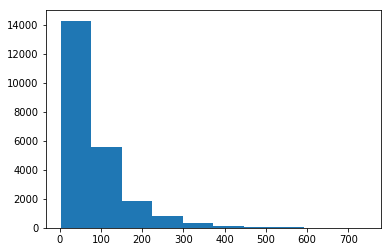

In [39]:
plt.hist(PM_less[name])
print()

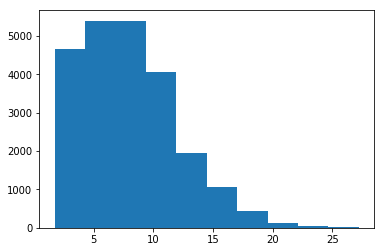

In [33]:
plt.hist(np.sqrt(PM_less[name]))
print()

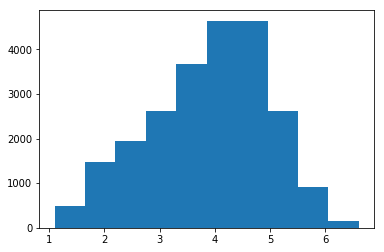

In [32]:
plt.hist(np.log(PM_less[name]))
print()

# Look at sqrt(PM 2.5) and log(PM 2.5) -- daily 

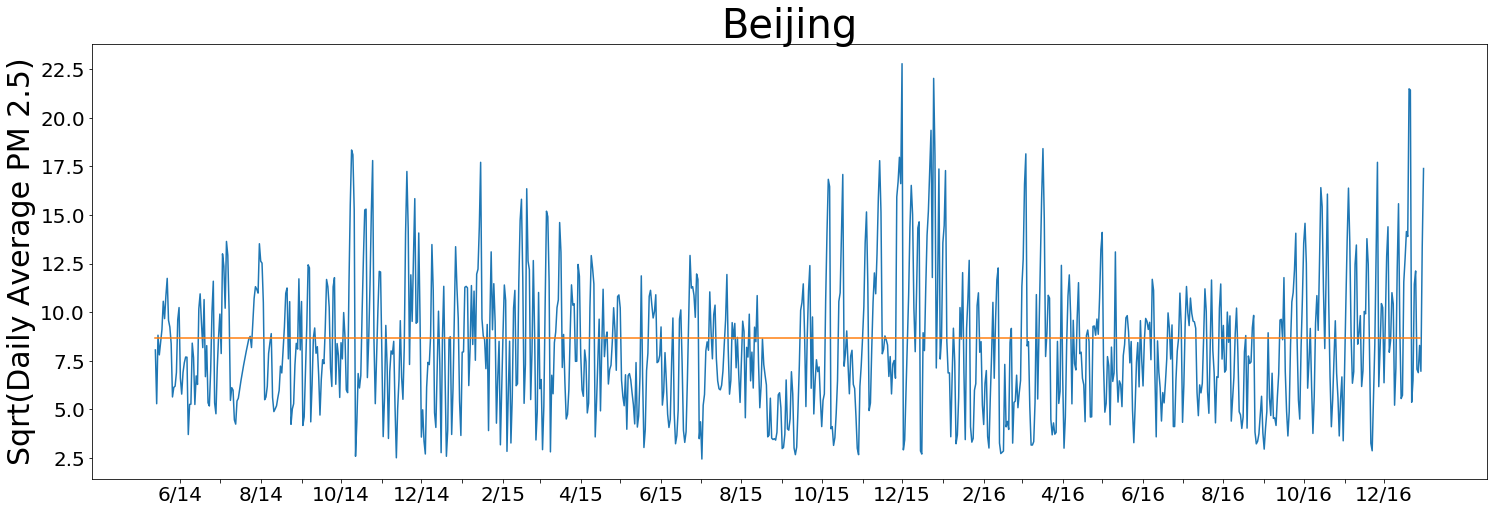

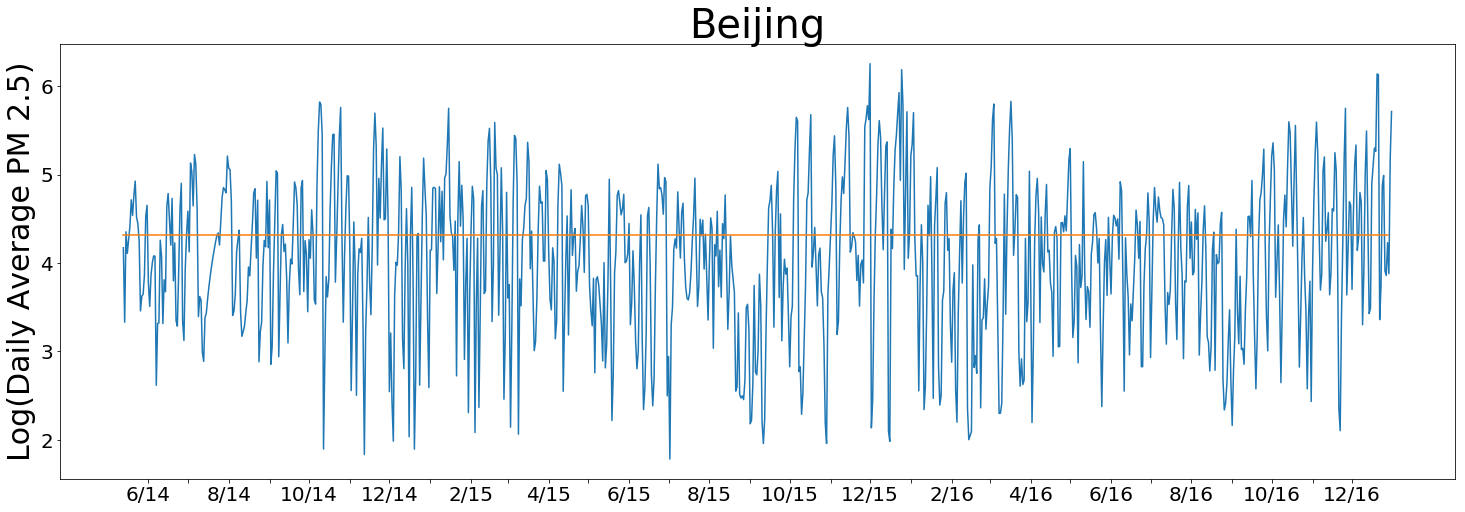

In [40]:
month_years = PM_DayAvg.drop_duplicates(subset=['month', 'year'])
labels = ['6/14', '', '8/14', '', '10/14', '', '12/14', '', '2/15','','4/15','','6/15','','8/15',
          '','10/15','','12/15','','2/16','','4/16','','6/16','','8/16','','10/16','','12/16']

for m in range(len(stations_to_use)):
    if m != 1:
        continue
    plt.figure(figsize=[25, 8])
    name = metros_to_use[m]
    plt.plot(np.sqrt(PM_DayAvg[name]))
    plt.plot([0,960],[np.sqrt(75), np.sqrt(75)])
    #plt.ylim(0, 550)
    plt.ylabel('Sqrt(Daily Average PM 2.5)', size=30)
    plt.yticks(size=20)
    plt.xticks(np.array(month_years.index)[1:], labels, size=20)
    plt.title(name, size=40)
    
    plt.figure(figsize=[25, 8])
    name = metros_to_use[m]
    plt.plot(np.log(PM_DayAvg[name]))
    plt.plot([0,960],[np.log(75), np.log(75)])
    #plt.ylim(0, 550)
    plt.ylabel('Log(Daily Average PM 2.5)', size=30)
    plt.yticks(size=20)
    plt.xticks(np.array(month_years.index)[1:], labels, size=20)
    plt.title(name, size=40)

Text(0.5,1,'Beijing')

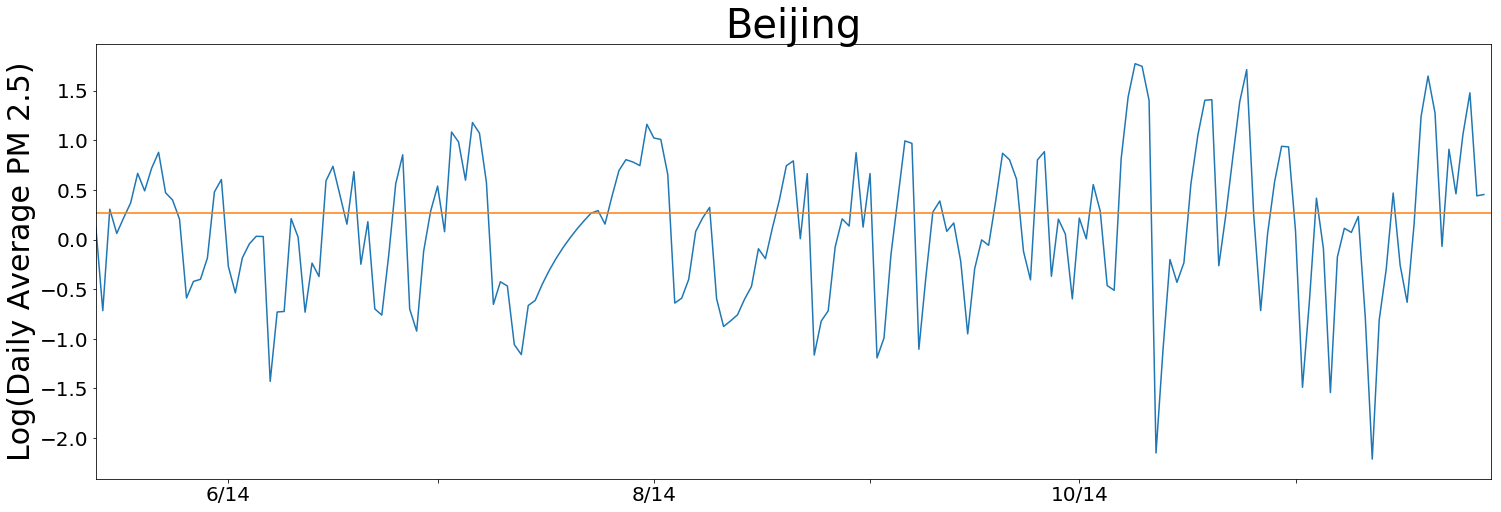

In [62]:
plt.figure(figsize=[25, 8])
name = 'Beijing'
series = np.log(PM_DayAvg[name])
S = series - series.mean()
plt.plot(S[:200])
plt.plot([0,200],[np.log(75)-series.mean(), np.log(75)-series.mean()])
plt.ylabel('Log(Daily Average PM 2.5)', size=30)
plt.yticks(size=20)
plt.xticks(np.array(month_years.index)[1:], labels, size=20)
plt.xlim([0, 200])
plt.title(name, size=40)

In [65]:
len(S[S>.2])

425

In [73]:
#1 std
print(len(S[S<-S.std()])/len(S))
print(len(S[S>S.std()])/len(S))

0.16493775933609958
0.14730290456431536


In [74]:
#2 std
print(len(S[S<-2*S.std()])/len(S))
print(len(S[S>2*S.std()])/len(S))

0.032157676348547715
0.011410788381742738


In [70]:
S.describe()

count    9.640000e+02
mean     7.877516e-16
std      8.582081e-01
min     -2.262208e+00
25%     -5.448313e-01
50%      7.862177e-02
75%      6.049750e-01
max      2.205466e+00
Name: Beijing, dtype: float64

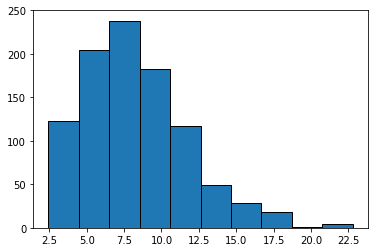

In [58]:
plt.hist(np.sqrt(PM_DayAvg[name]), edgecolor='black')
print()

0.8582080752276264


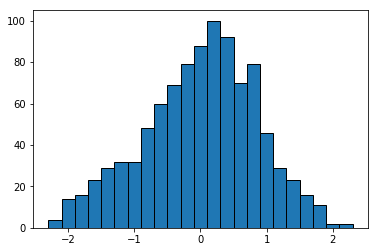

In [86]:
plt.hist(S, edgecolor='black', bins=[-2.3, -2.1, -1.9, -1.7, -1.5,
                                    -1.3, -1.1, -.9, -.7, -.5, -.3, 
                                     -.1, .1, .3, .5, .7, .9, 1.1, 
                                     1.3, 1.5, 1.7, 1.9, 2.1, 2.3])
print(S.std())

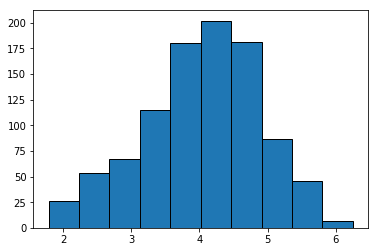

In [67]:
plt.hist(np.log(PM_DayAvg[name]), edgecolor='black')
print()

## Percentage of Days where Average PM2.5 exceeded threshold of 75. 

In [20]:
for m in range(len(stations_to_use)):
    name = metros_to_use[m]
    above = len(PM_DayAvg[PM_DayAvg[name] > 75])
    percent = round((above/len(PM_DayAvg))*100, 1)
    print(name, str(percent)+'%')

Baotou 15.8%
Beijing 39.8%
Changsha 27.8%
Chengdu 23.8%
Chongqing 21.2%
Fuzhou 2.5%
Guangzhou 7.0%
Harbin 22.6%
Kunming 0.5%
Lhasa 2.0%
Nanjing 28.4%
Nanning 8.1%
Qingdao 10.7%
Shanghai 17.3%
Shenyang 28.1%
Urumqi 24.1%
Wuhan 29.0%
Xian 19.2%
Xining 18.4%
Yinchuan 18.7%
Zhengzhou 43.5%


# Does hour matter? (E.g. more pollution during the day?) 

Actually differs significantly from city-to-city!

/Users/Brenton/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


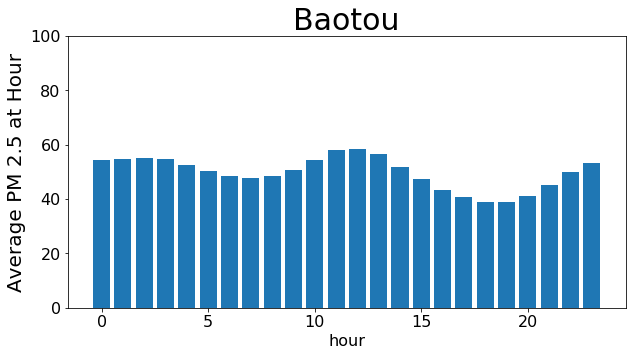

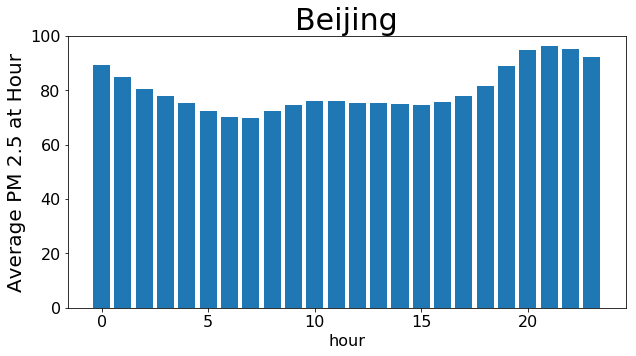

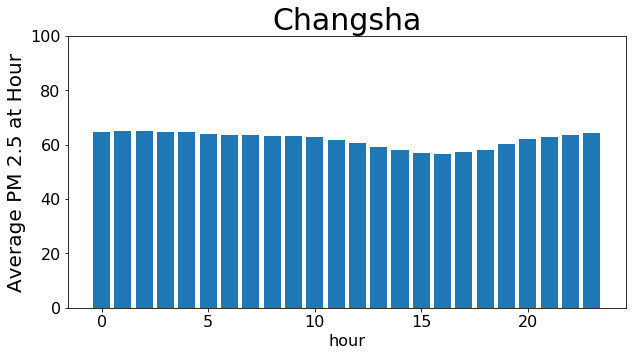

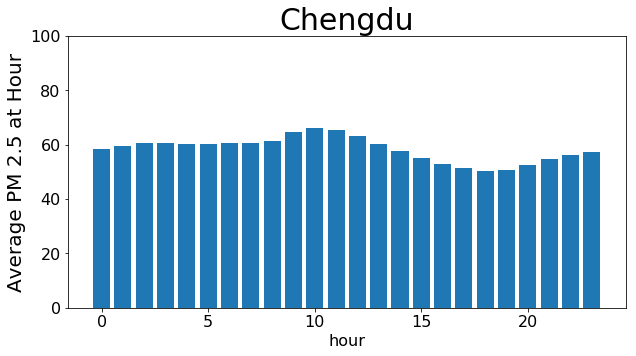

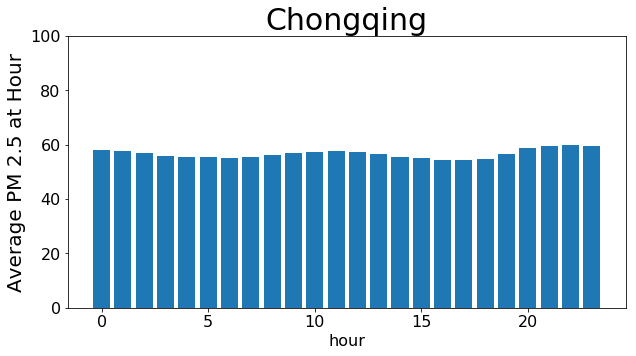

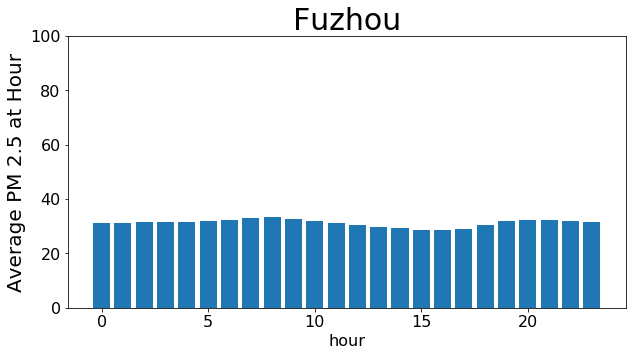

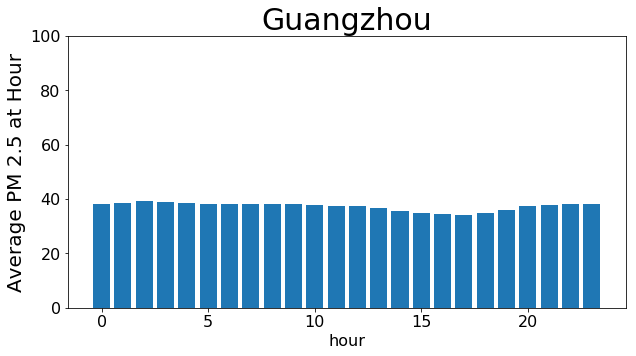

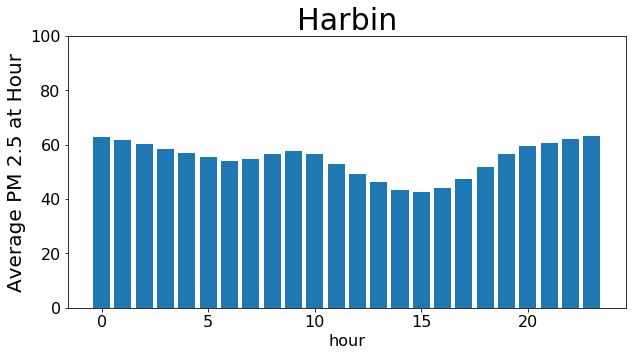

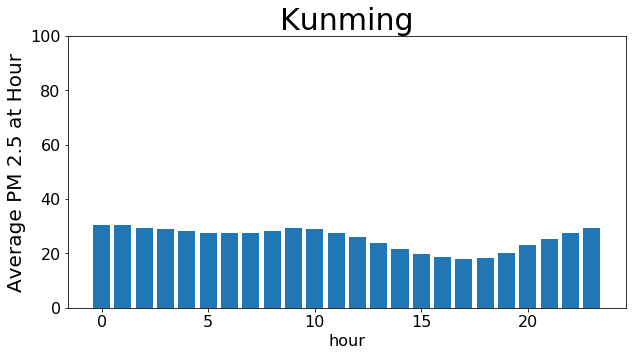

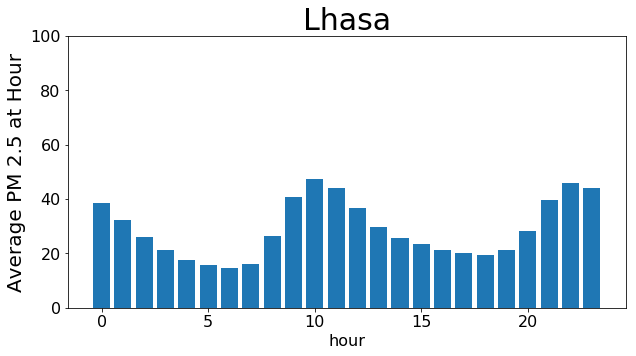

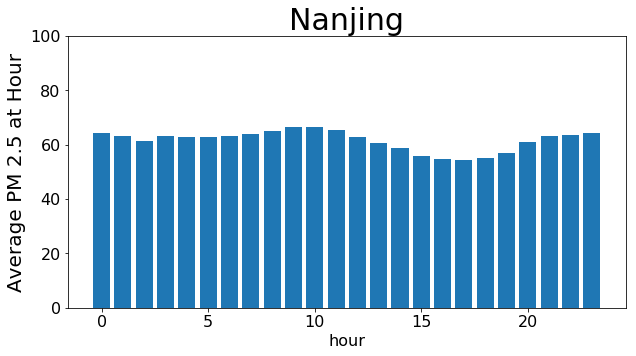

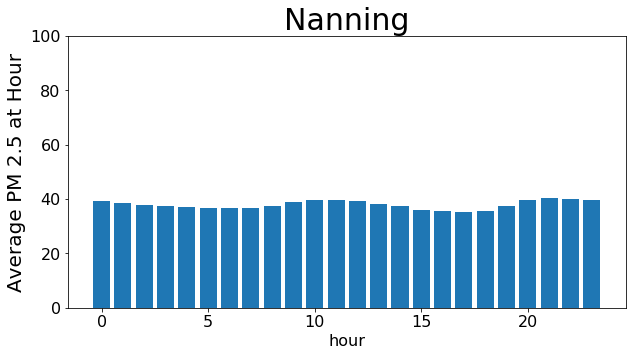

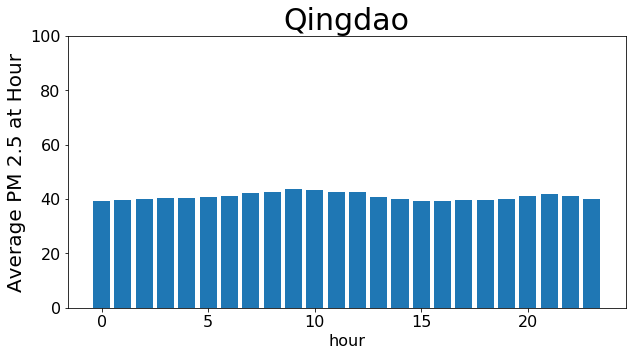

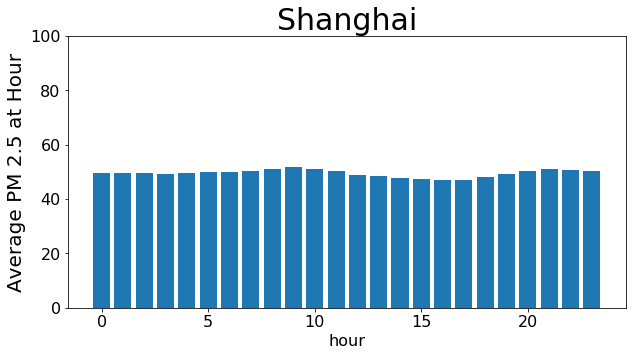

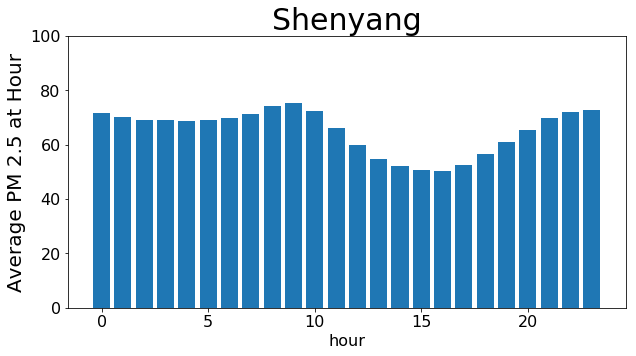

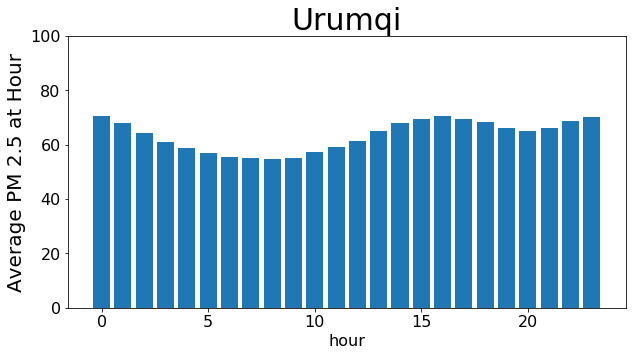

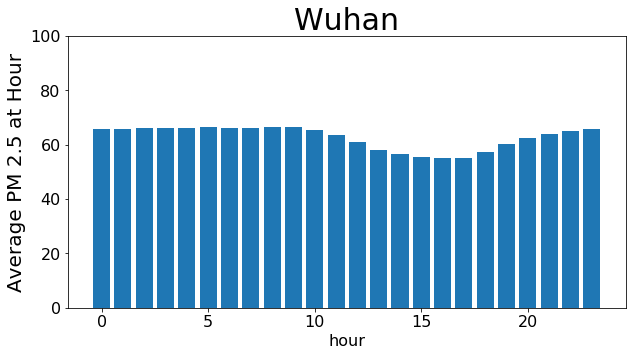

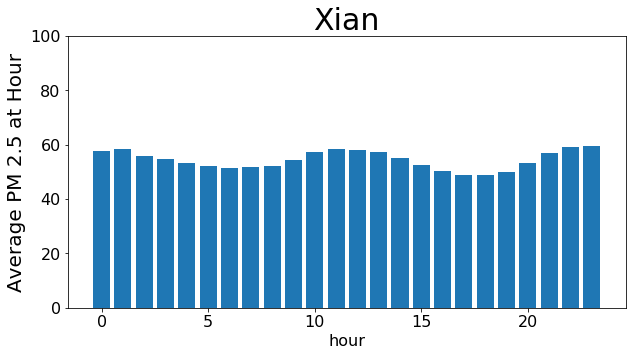

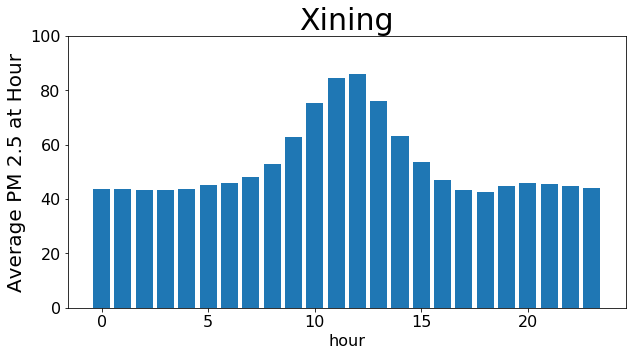

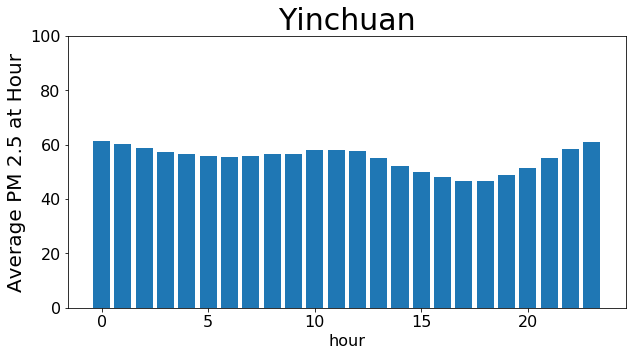

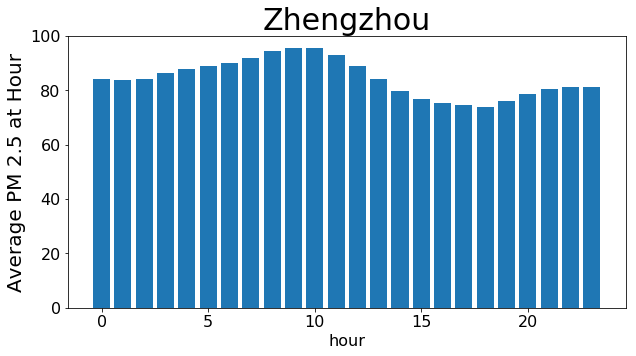

In [21]:
PMhour = PM_less.groupby('hour').mean().reset_index()
for m in range(len(stations_to_use)):
    name = metros_to_use[m]
    plt.figure(figsize=[10, 5])
    hour_array = PMhour[name]
    plt.bar(hour_array.index, hour_array.values)
    plt.xlabel('hour', size=16)
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.ylim([0, 100])
    plt.ylabel('Average PM 2.5 at Hour', size=20)
    plt.title(name, size=30)

# Plot Autocorrelation (ACF) by Day for each city 

/Users/Brenton/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


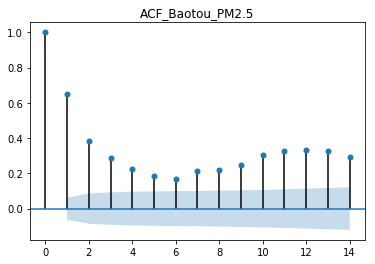

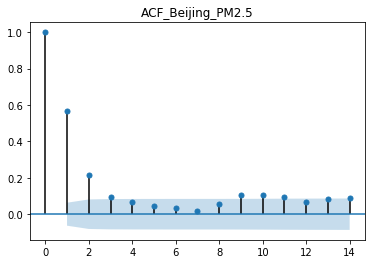

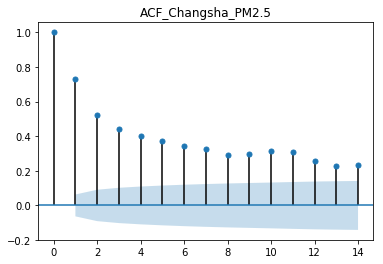

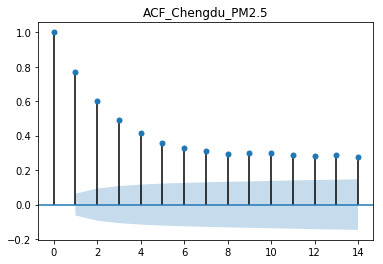

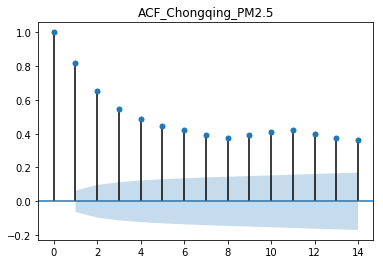

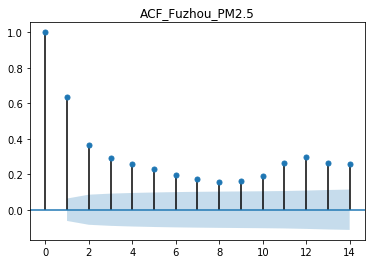

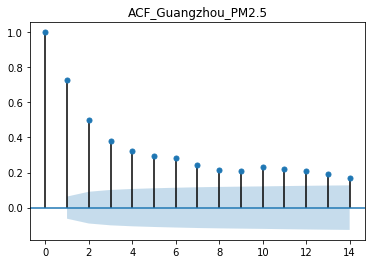

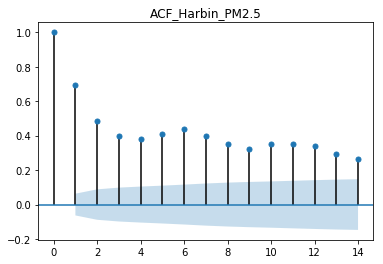

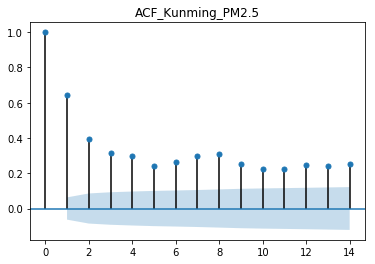

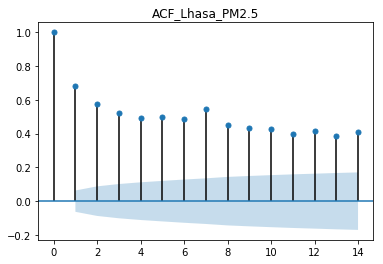

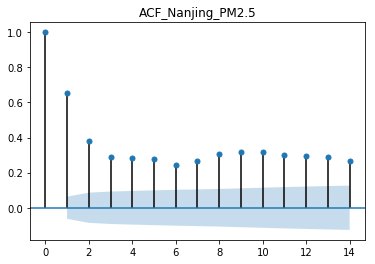

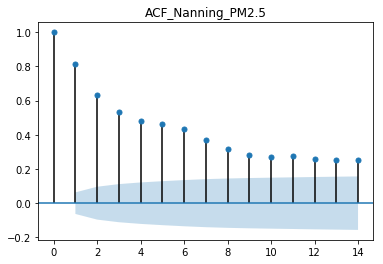

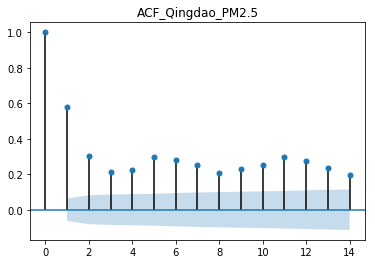

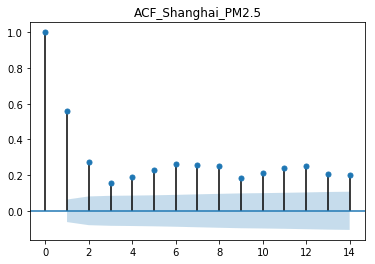

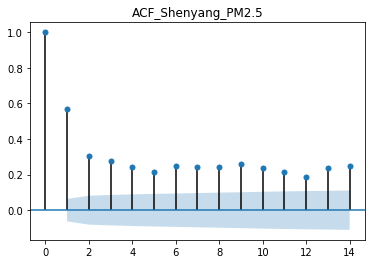

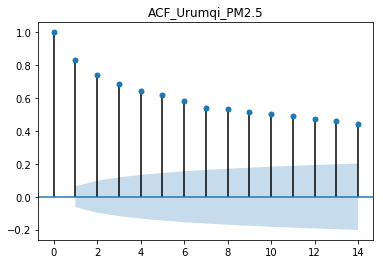

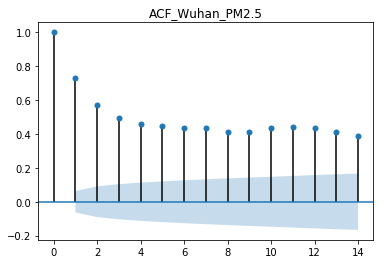

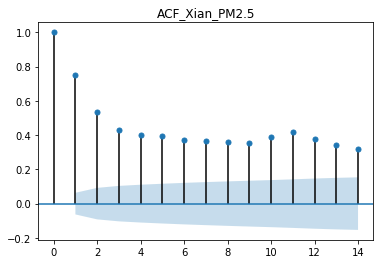

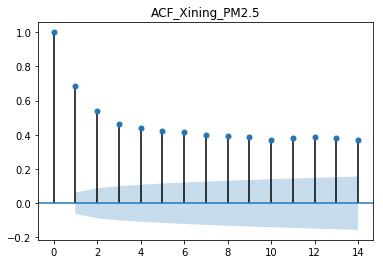

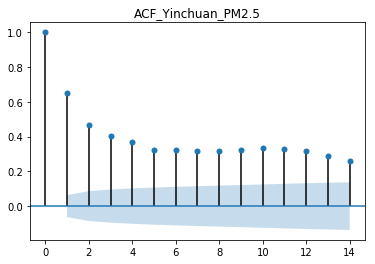

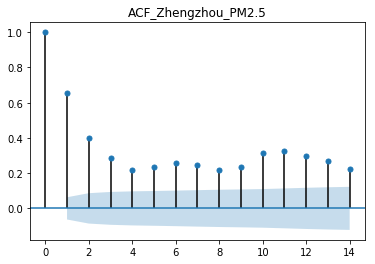

In [22]:
for m in range(len(stations_to_use)):
    plt.figure(figsize=[25, 8])
    name = metros_to_use[m]
    plot_acf(x=PM_DayAvg[name], lags=14, title="ACF_"+name+'_PM2.5')

# Plot Autocorrelation (ACF) by Hour for each city 

/Users/Brenton/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


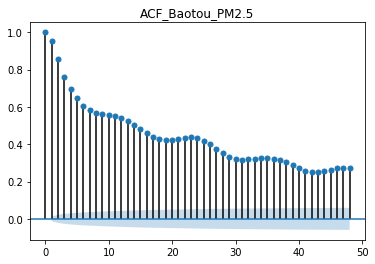

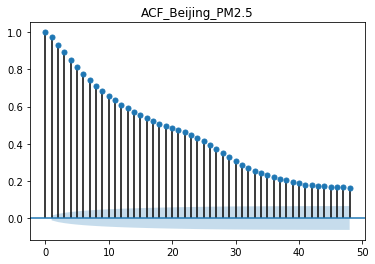

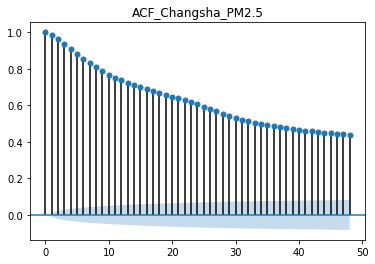

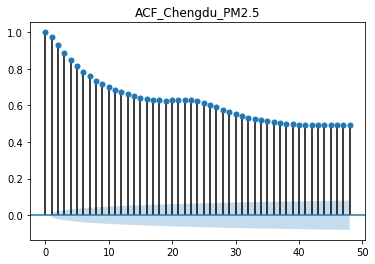

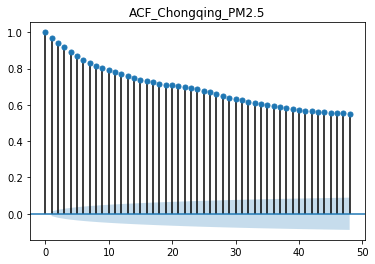

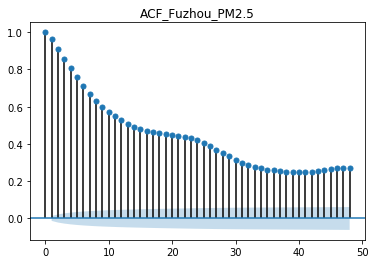

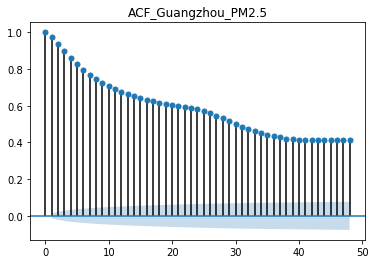

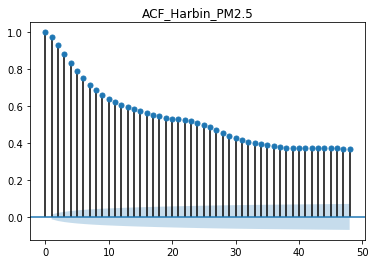

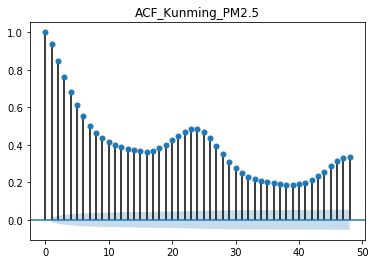

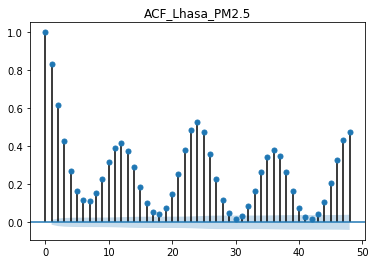

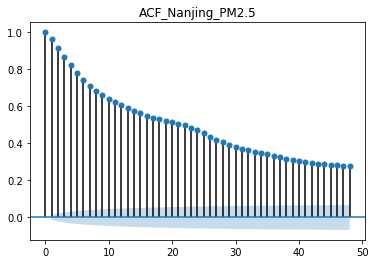

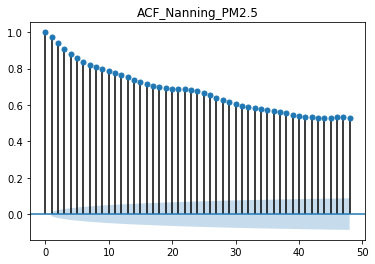

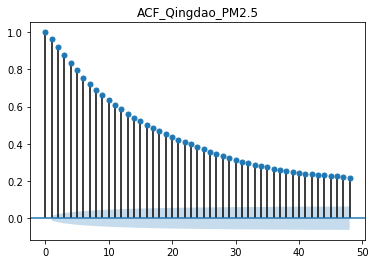

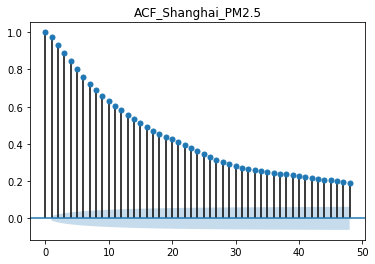

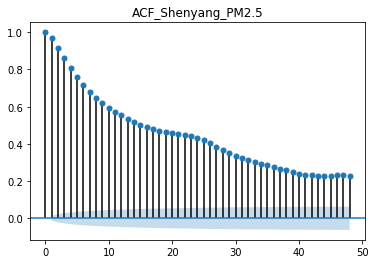

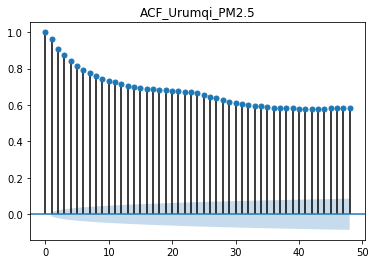

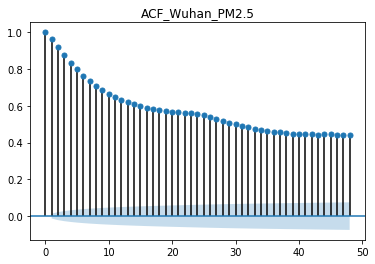

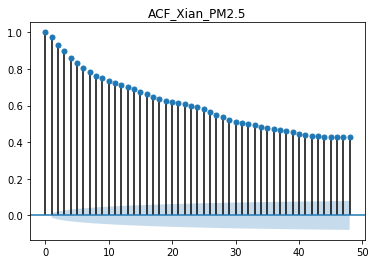

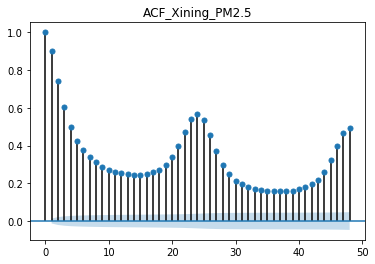

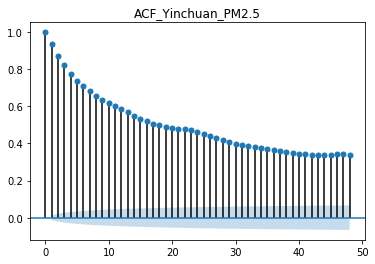

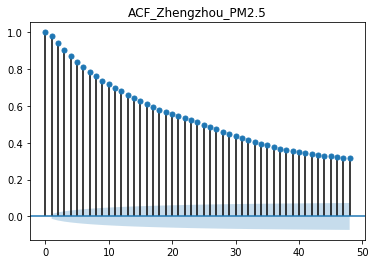

In [23]:
for m in range(len(stations_to_use)):
    plt.figure(figsize=[25, 8])
    name = metros_to_use[m]
    plot_acf(x=PM_less[name], lags=48, title="ACF_"+name+'_PM2.5')

# Find CCF at t-24 between Beijing and each city 

In [48]:
for m in range(len(stations_to_use)):
    name = metros_to_use[m]
    if name == 'Beijing':
        pass
    else:
        ccf24 = round(ccf(PM_less['Beijing'], PM_less[name])[24], 3)
        print(name, ccf24)

Baotou 0.391
Changsha 0.105
Chengdu 0.189
Chongqing 0.119
Fuzhou 0.032
Guangzhou 0.11
Harbin 0.228
Kunming 0.045
Lhasa 0.112
Nanjing 0.117
Nanning 0.129
Qingdao 0.142
Shanghai 0.022
Shenyang 0.214
Urumqi 0.098
Wuhan 0.141
Xian 0.335
Xining 0.15
Yinchuan 0.29
Zhengzhou 0.26
